Pass Initial Test, Moving on to Loading Session...


EXPERIMENT1, Recording 1
Open Ephys GUI Recording
ID: 0x148d83efb90
Format: Binary
Directory: SNARE-38-TEST3_2025-07-24_16-05-17_002\Record Node 111\experiment1\recording1
Experiment Index: 0
Recording Index: 0
Processor ID: 100, Stream Name: Rhythm Data, Line: 1 (main sync line))
  First event sample number: 12828385
  Last event sample number: 21609448
  Total sync events: 404
  Sample rate: 5000.0
Channels: ['CH1', 'CH5', 'CH7', 'CH11', 'ADC1'] 

Loaded 569 MessageCenter entries
[Time: 2564.595200 s] Message: Starting at 0.01 mA
[Time: 2565.665800 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 2568.342600 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 2569.566200 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 2570.369400 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 2571.937200 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 2574.002000 s] Message: Starting at 0.05 mA
[Time: 2579.164400 s] Message: Starting at 0.05 mA
[Time: 2579.96760

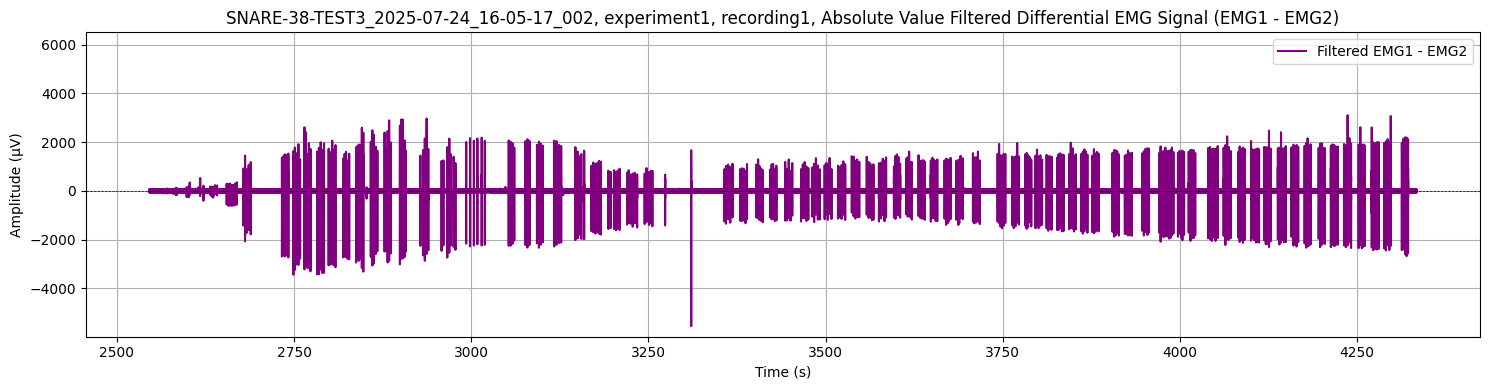

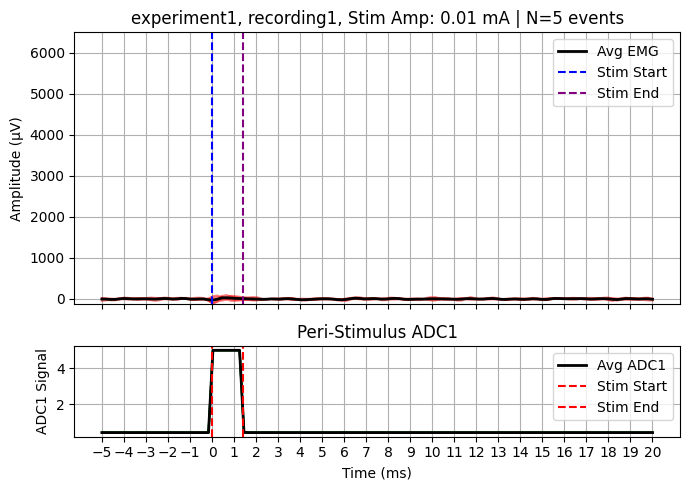

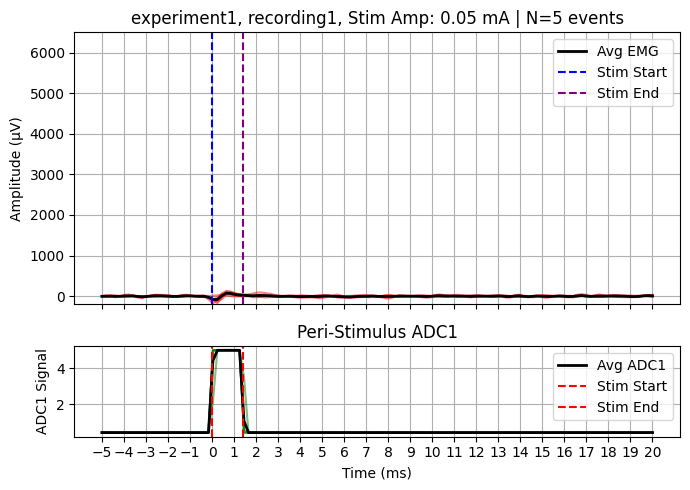

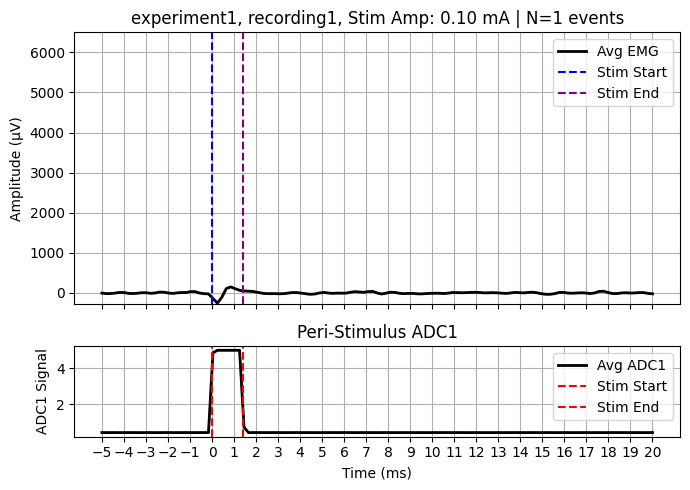

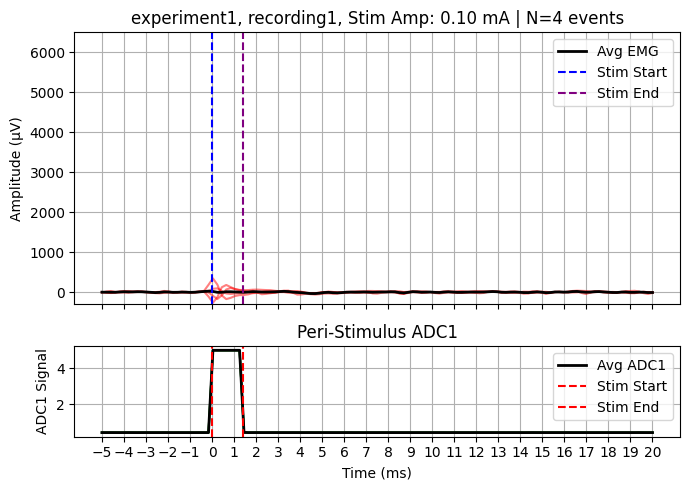

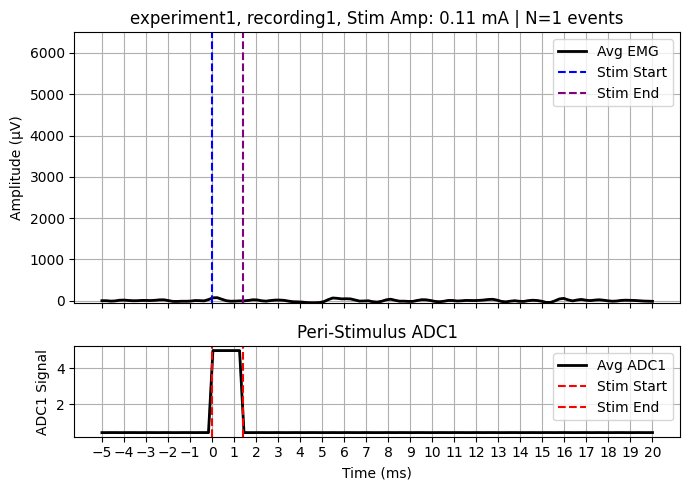

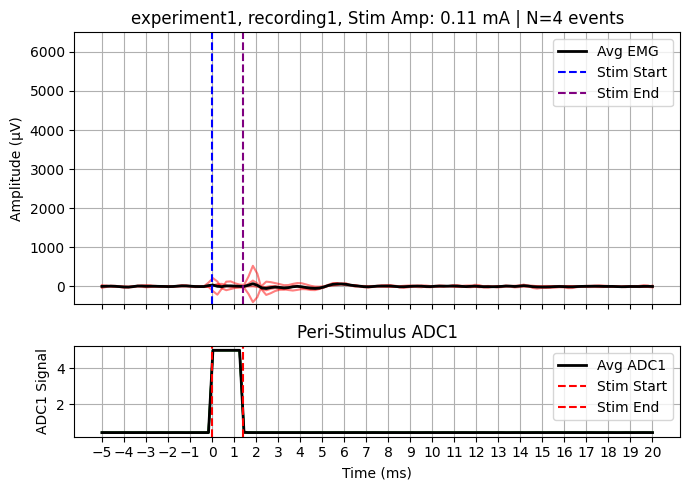

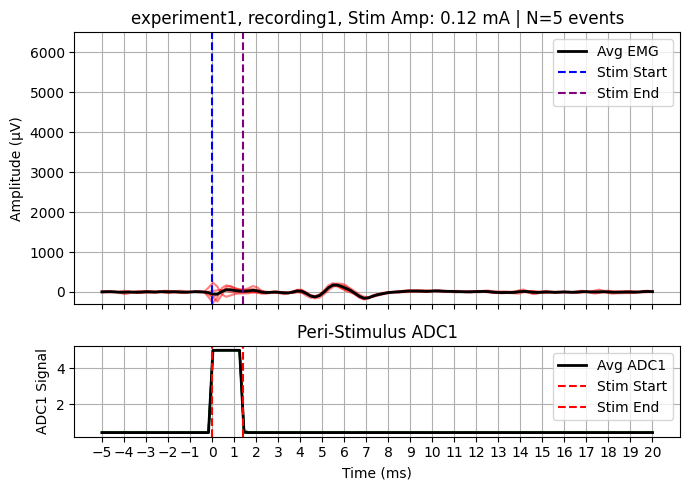

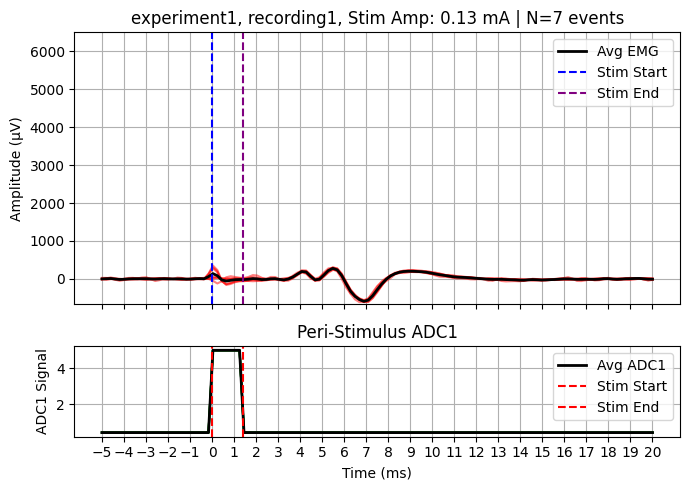

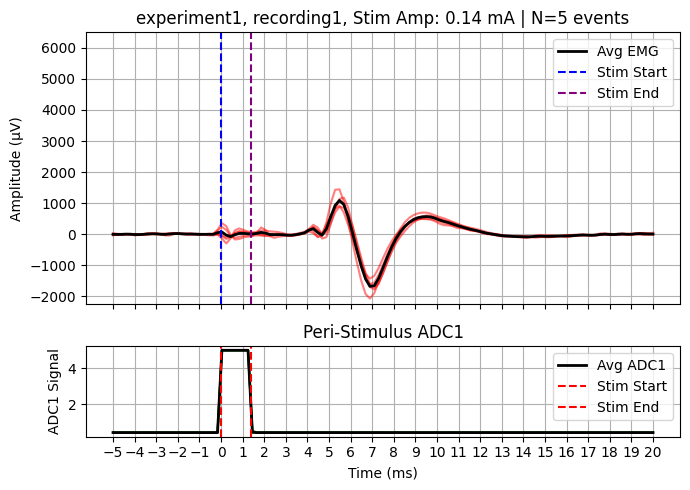

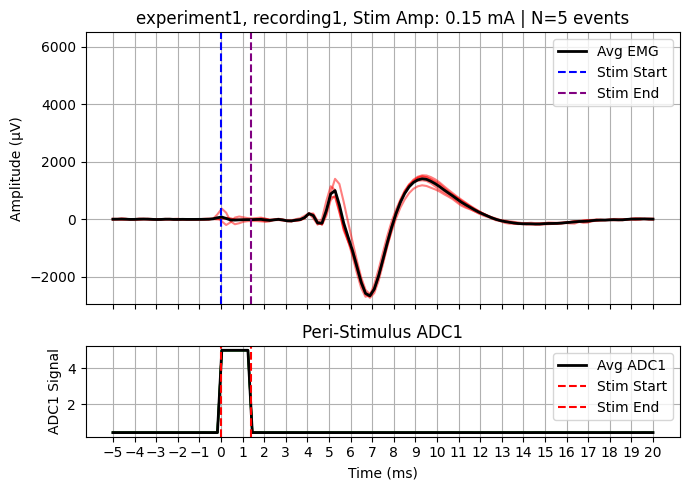

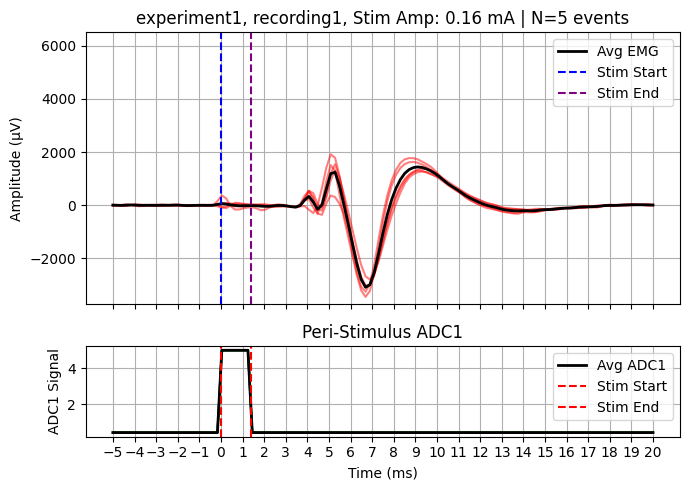

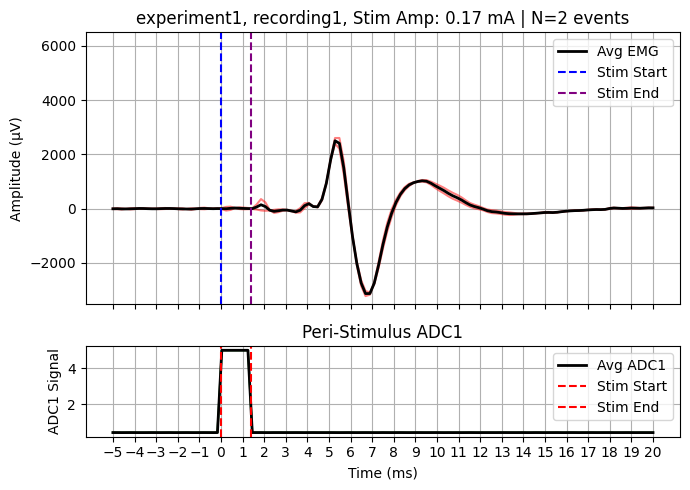

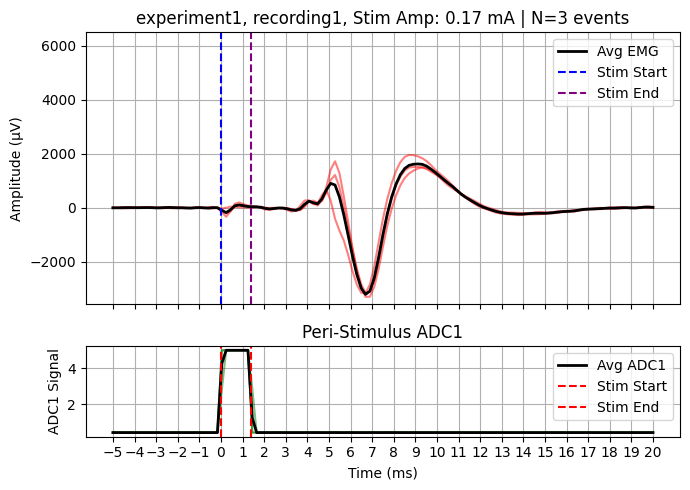

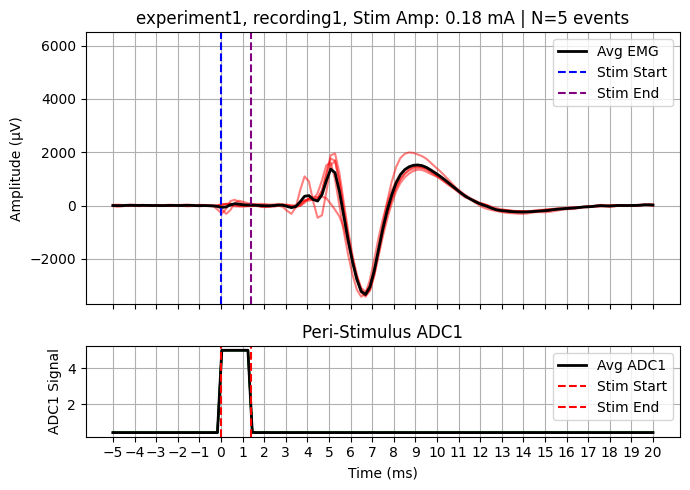

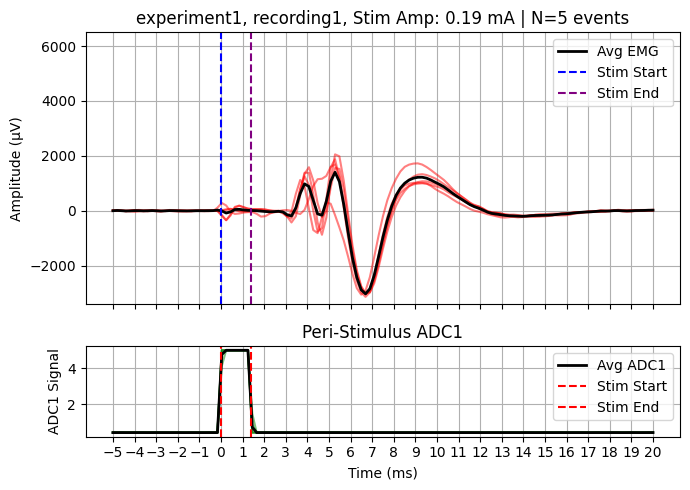

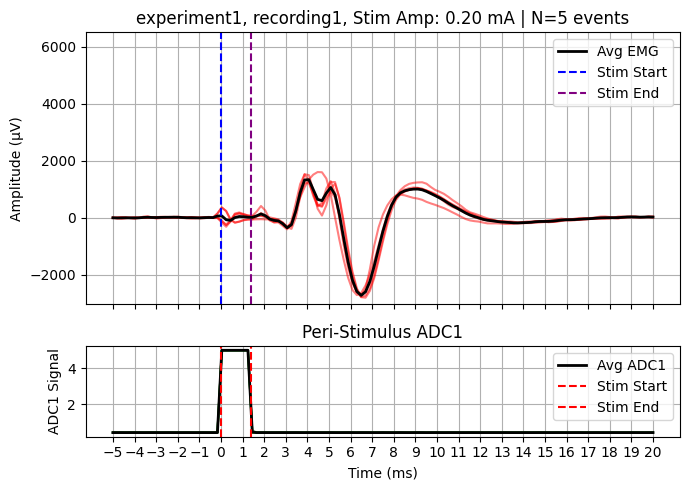

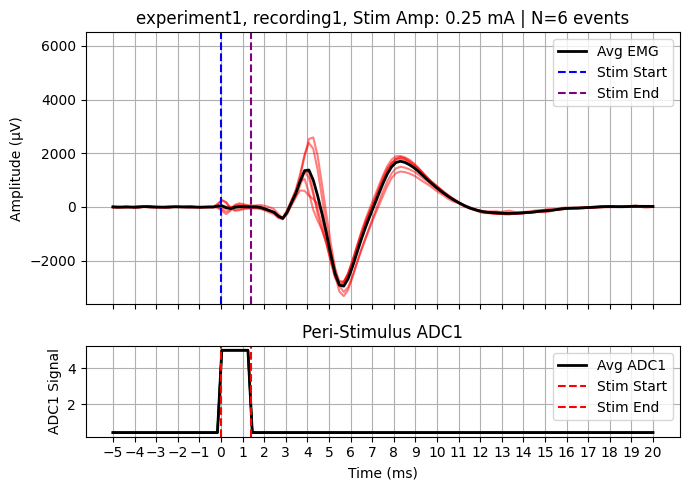

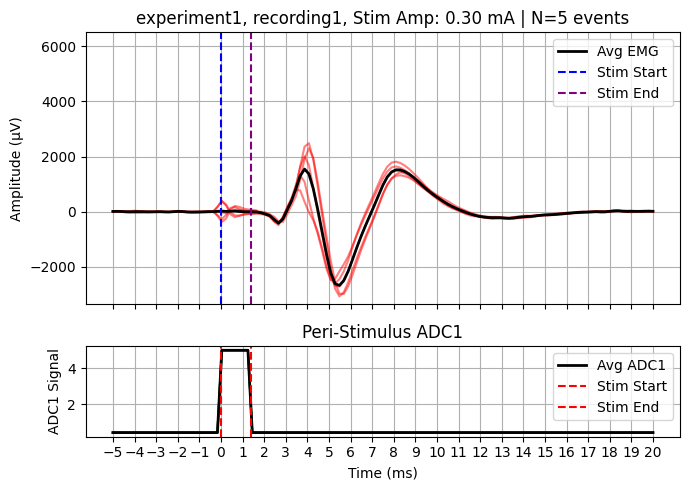

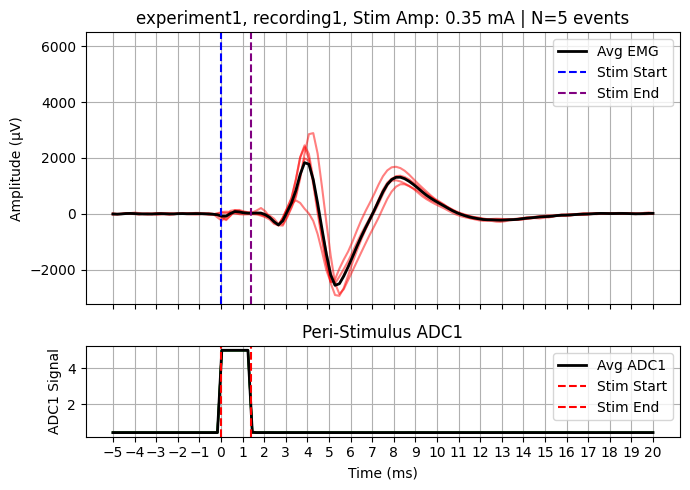

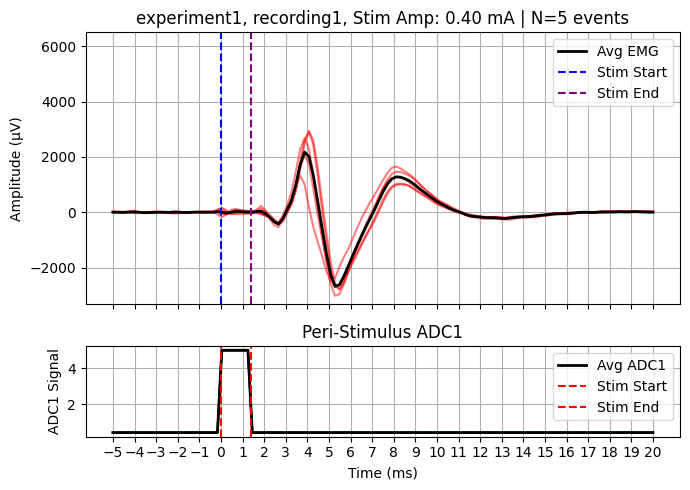

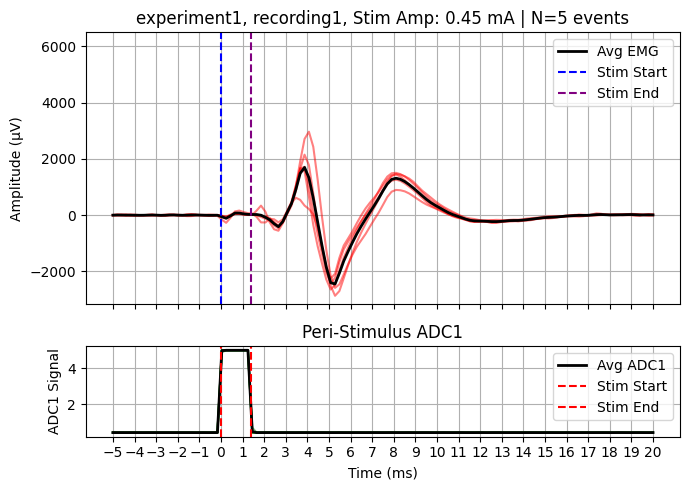

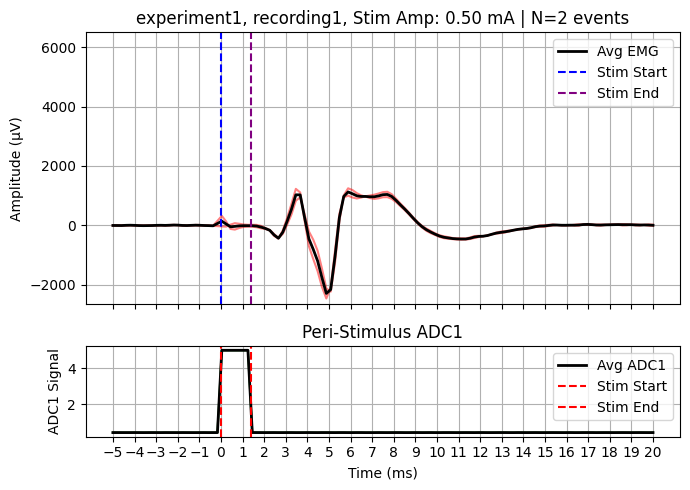

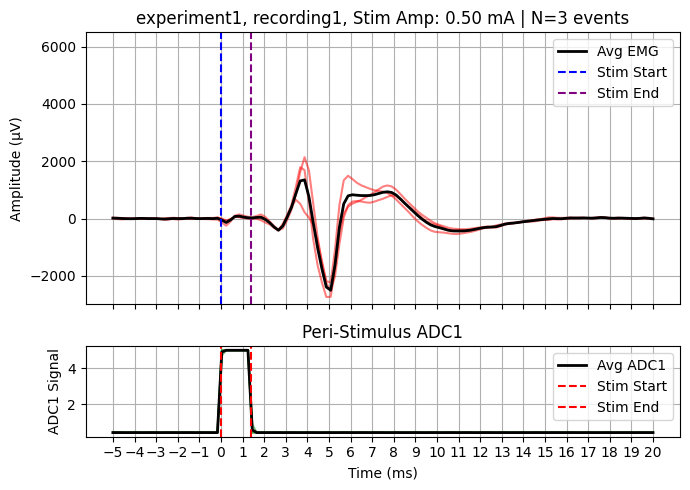

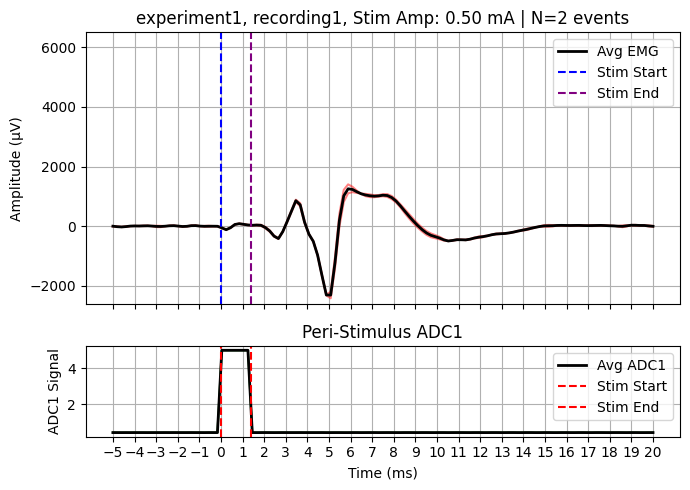

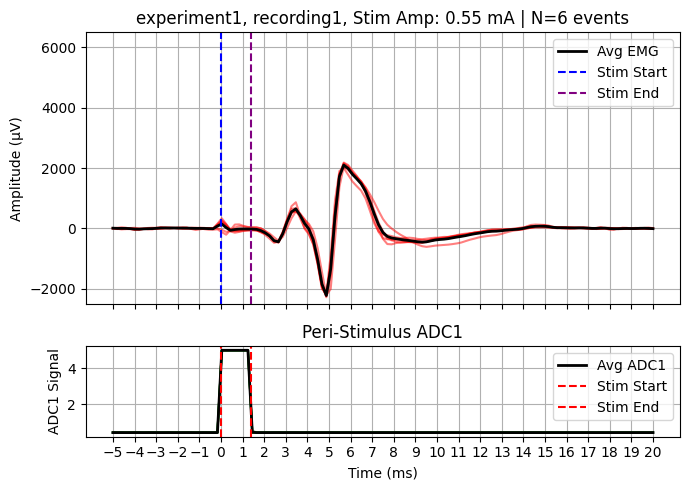

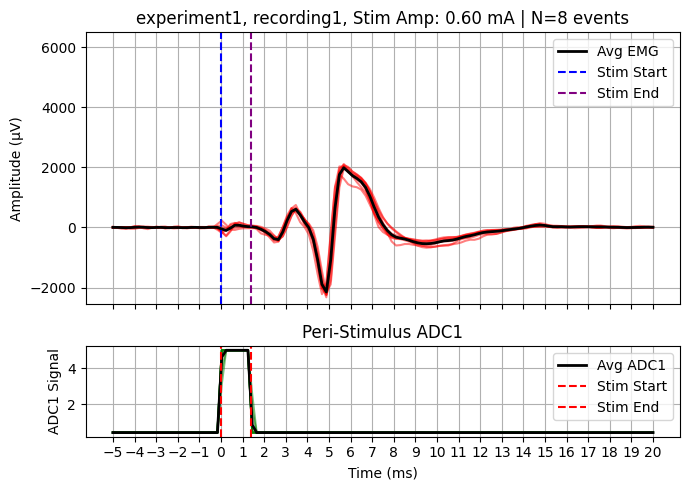

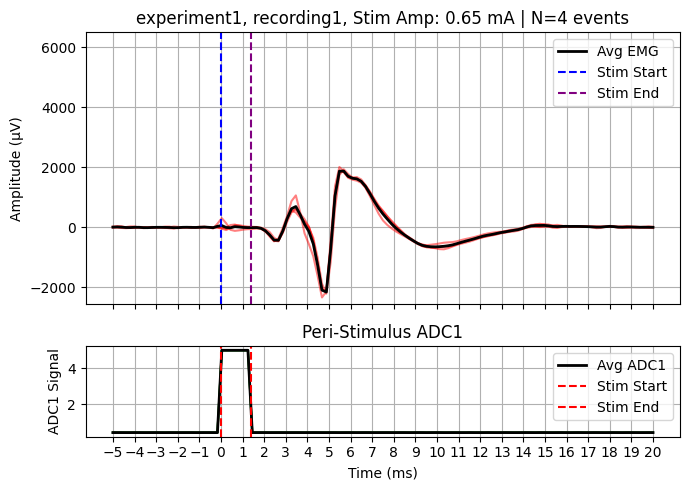

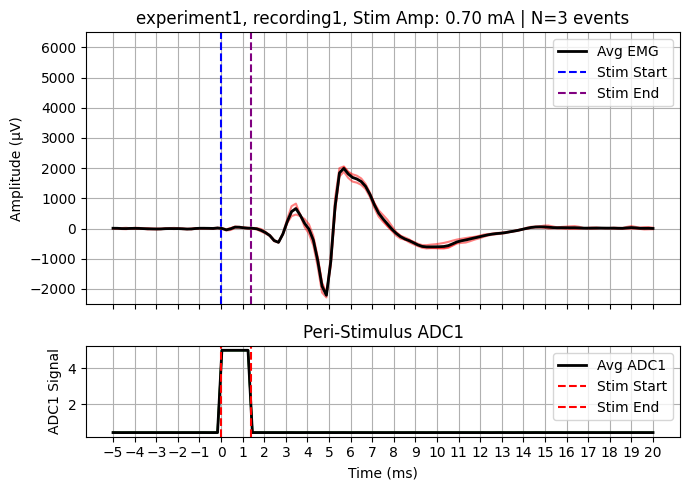

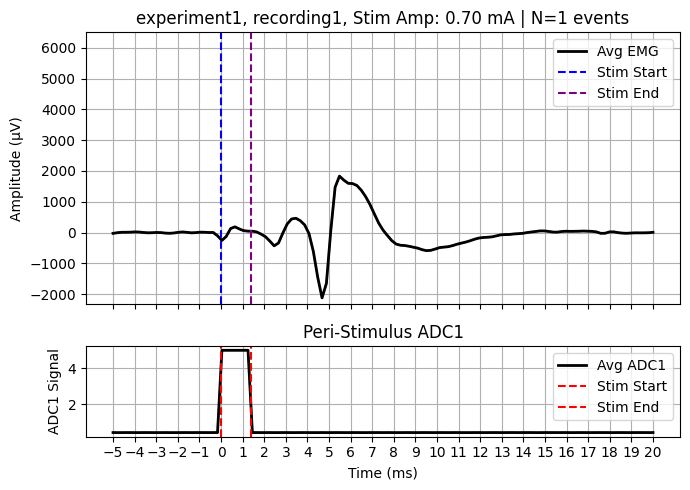

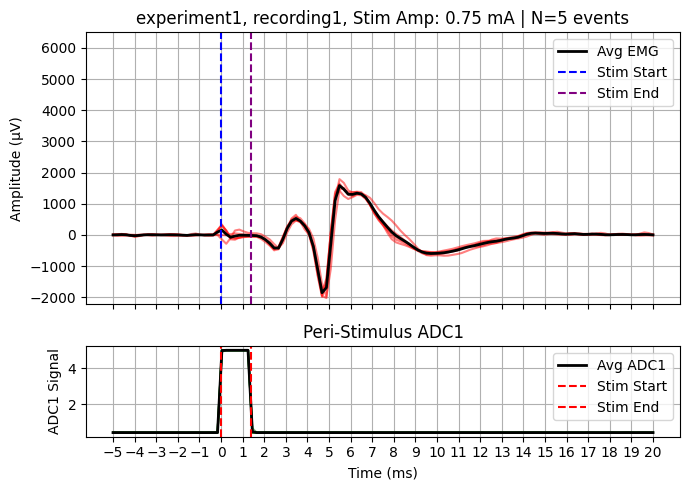

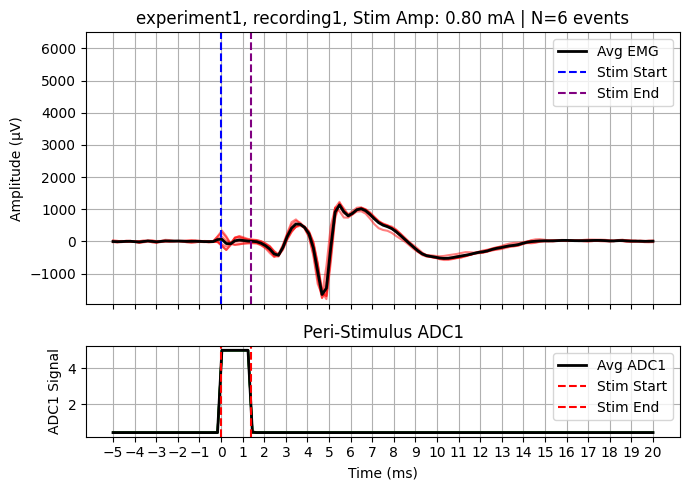

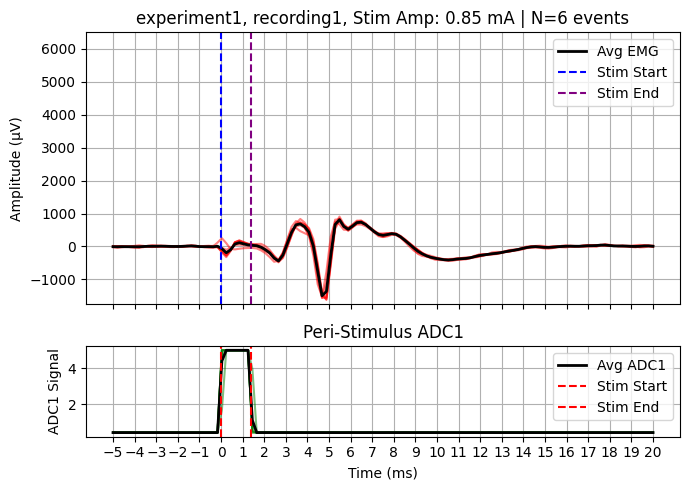

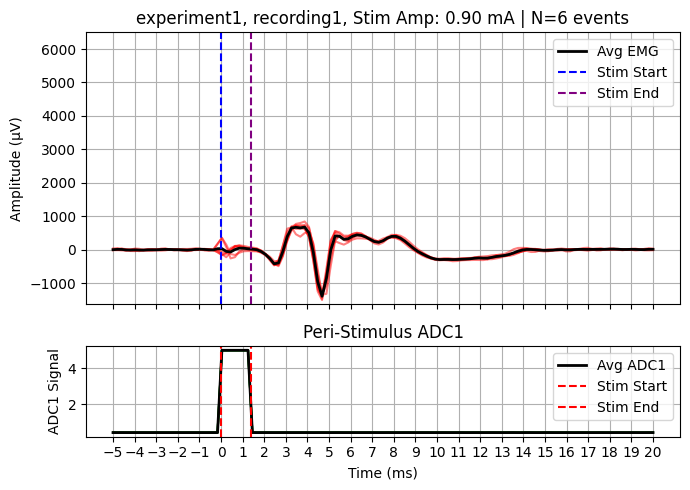

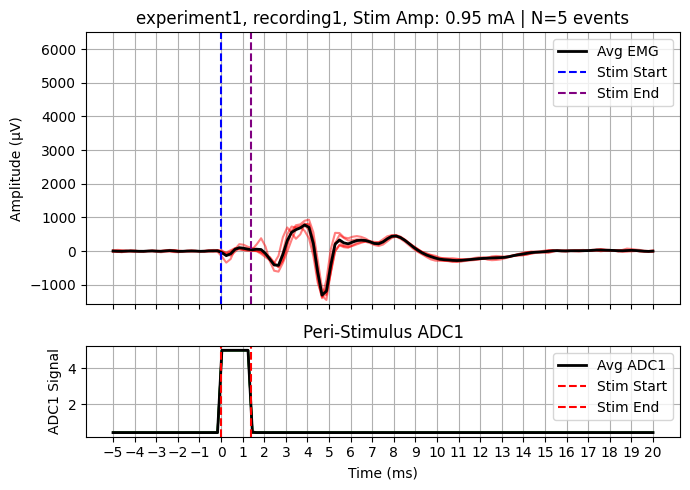

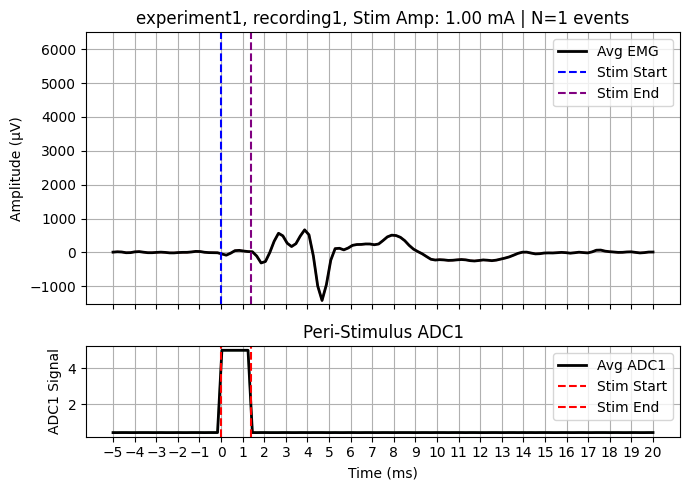

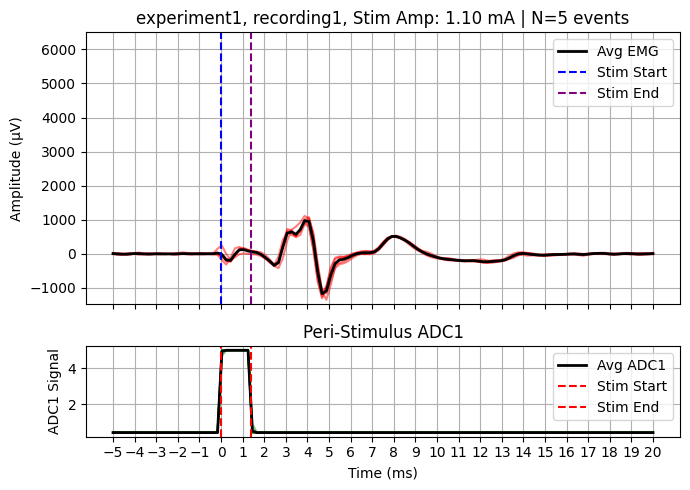

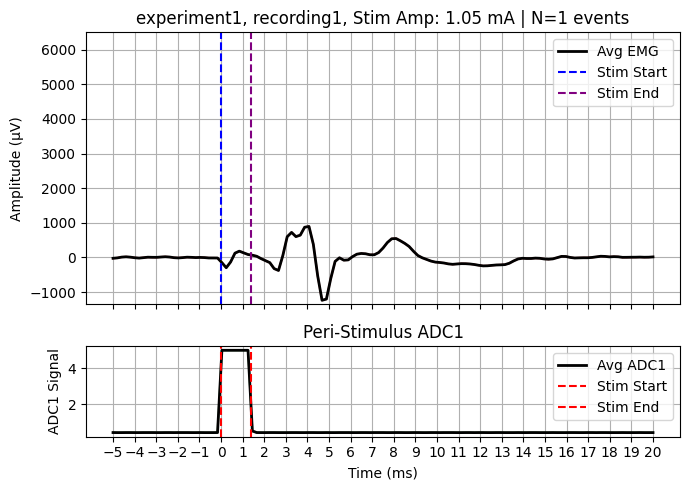

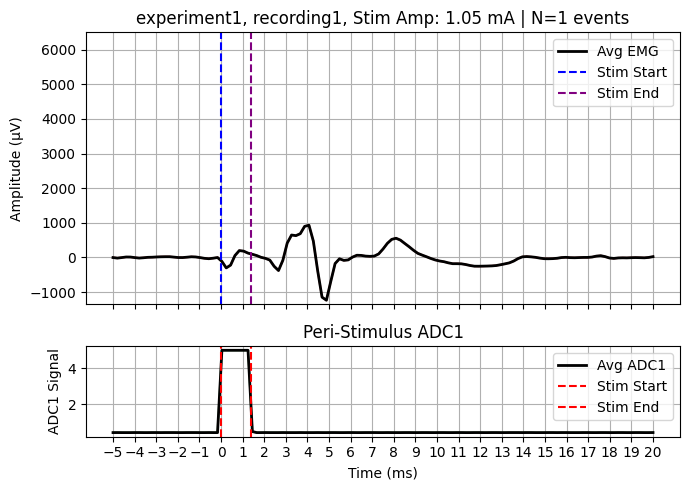

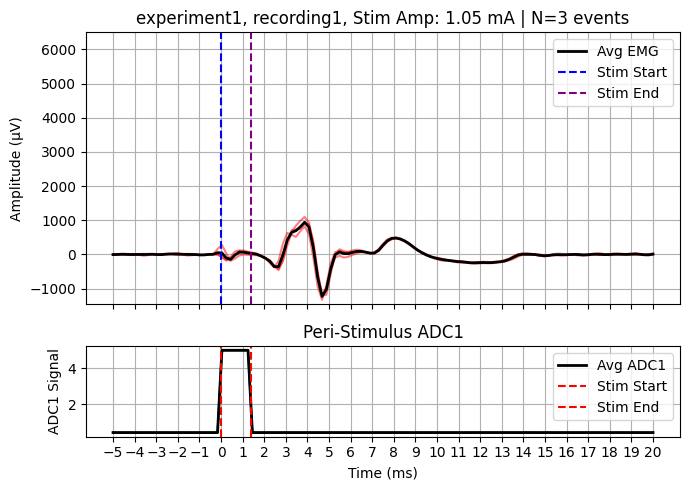

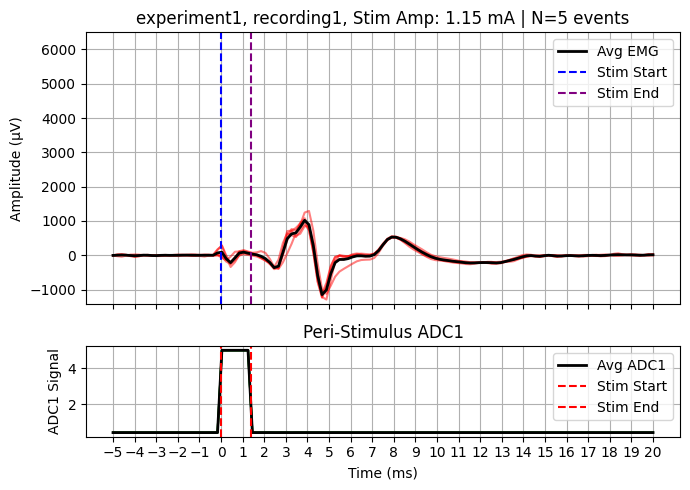

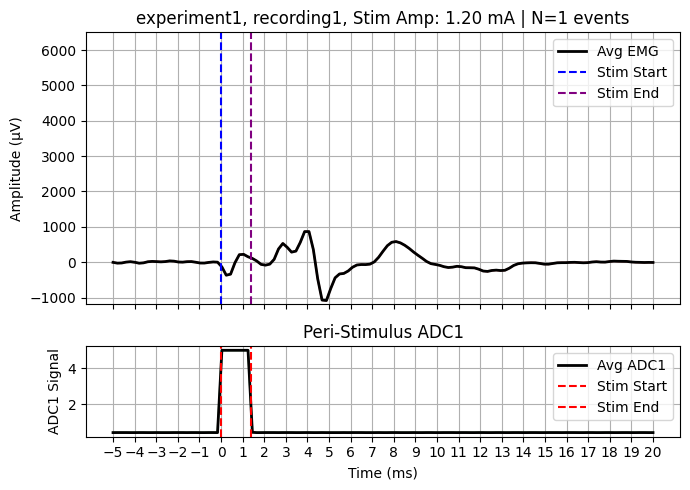

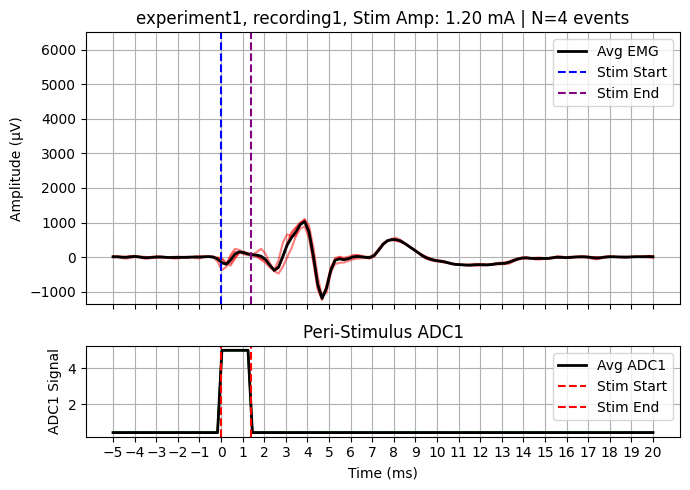

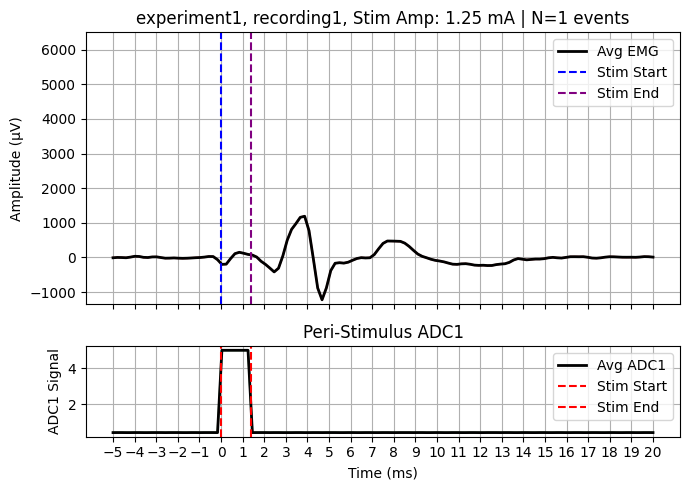

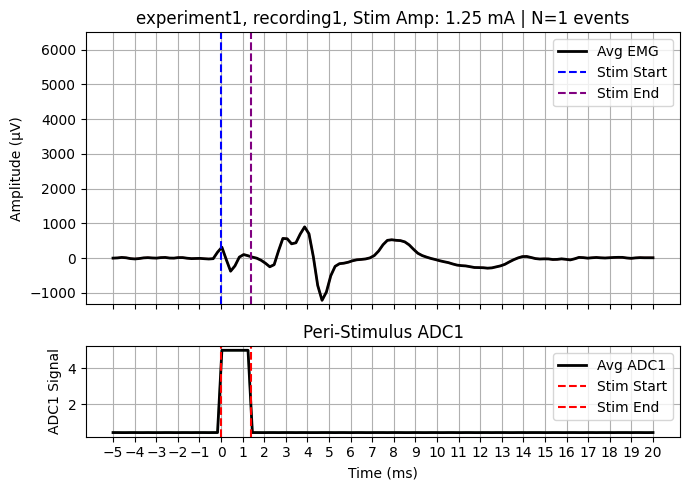

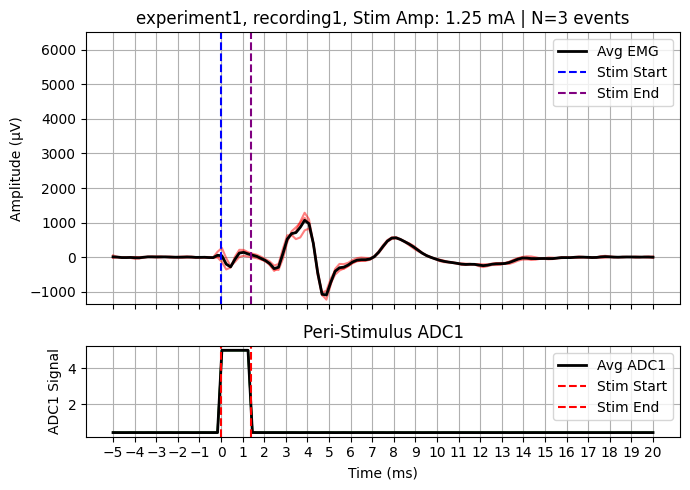

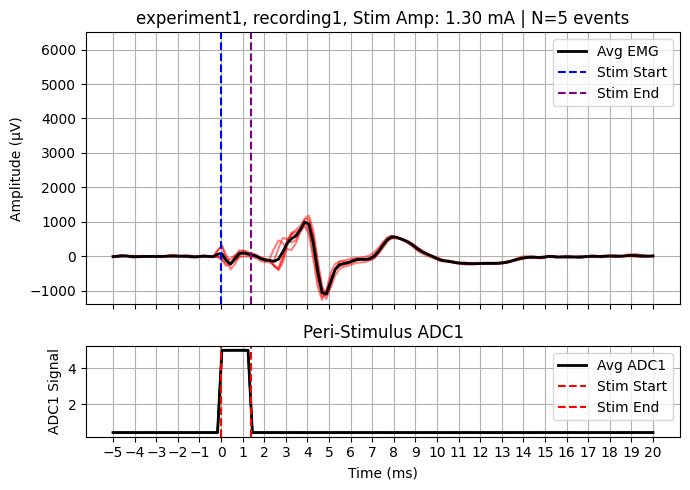

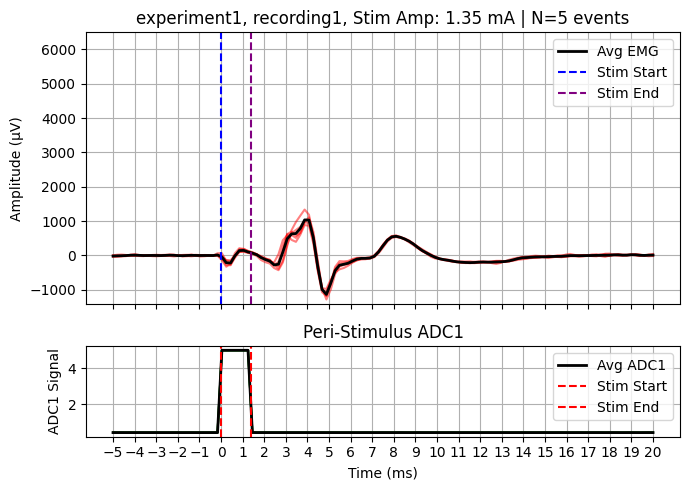

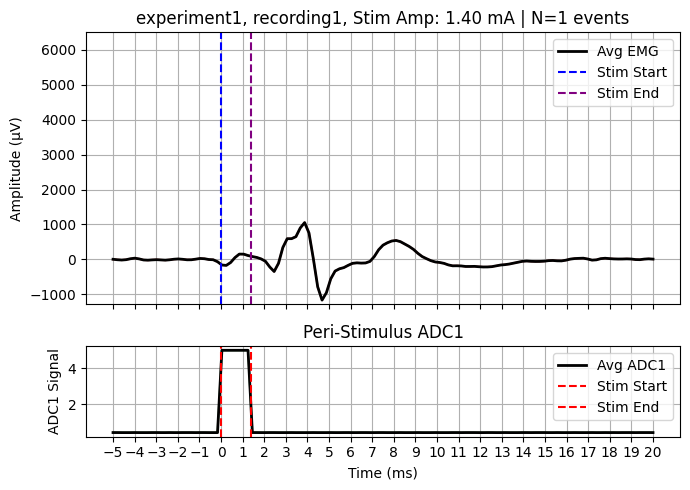

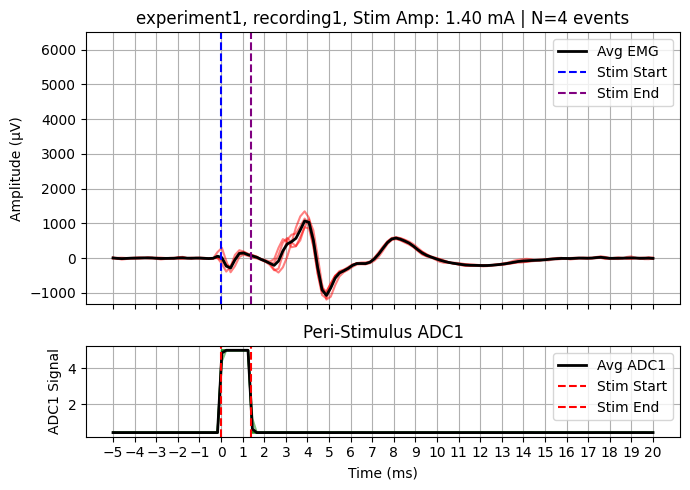

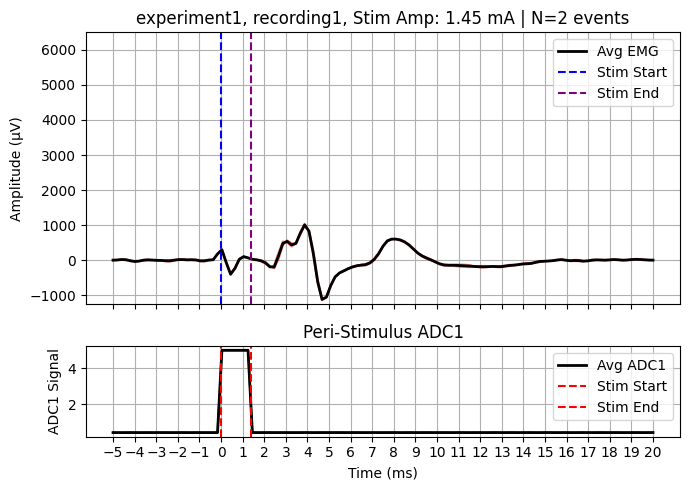

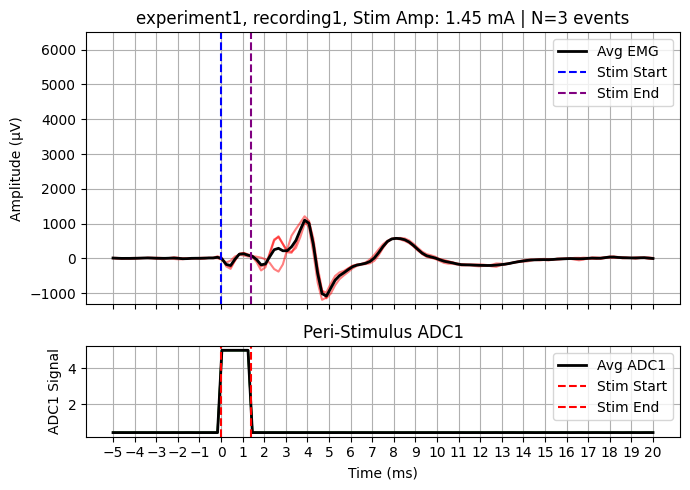

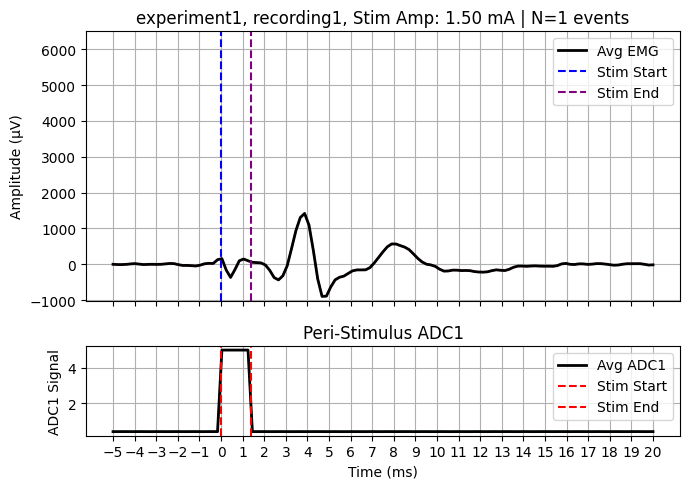

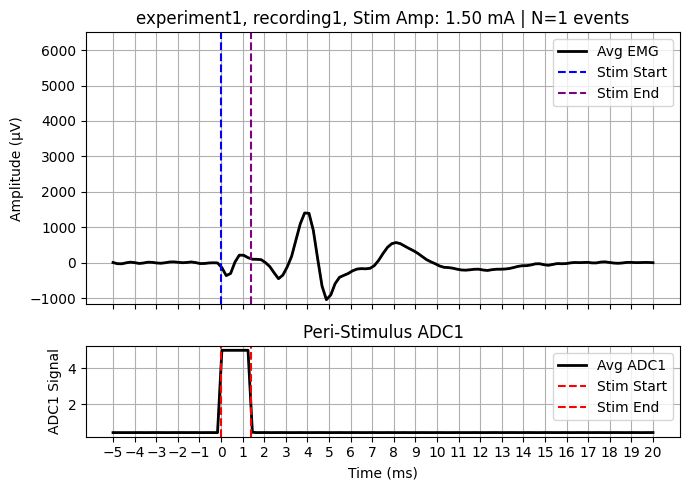

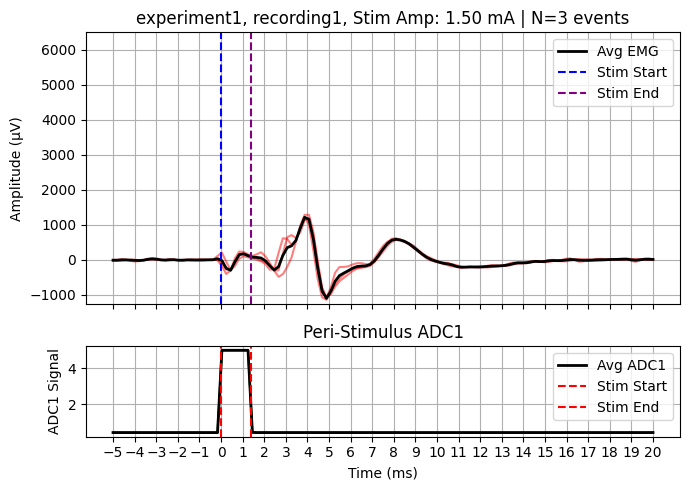

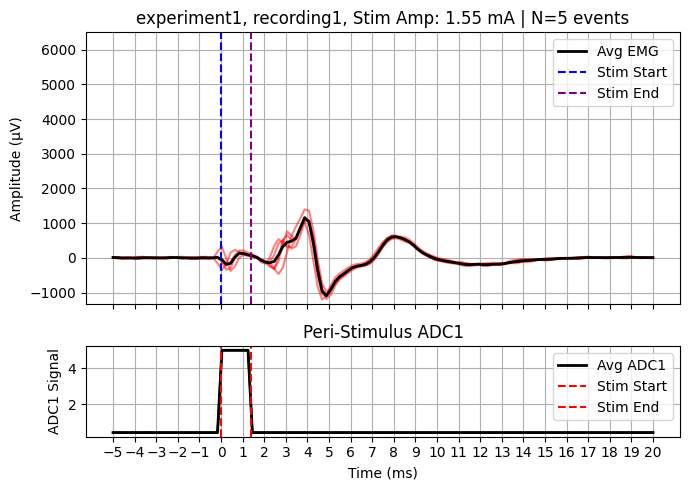

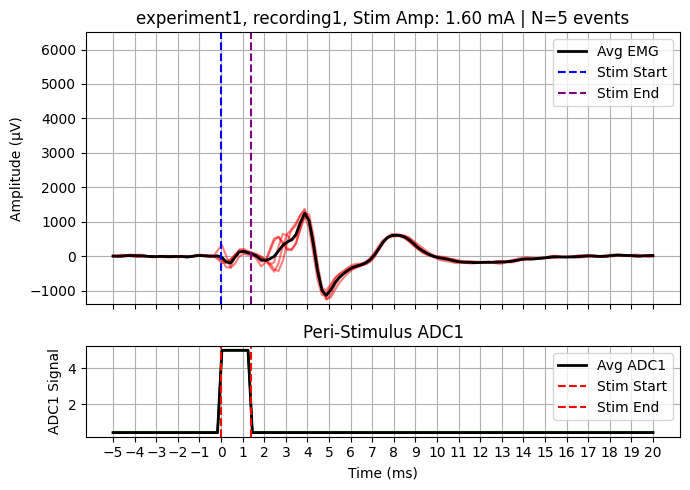

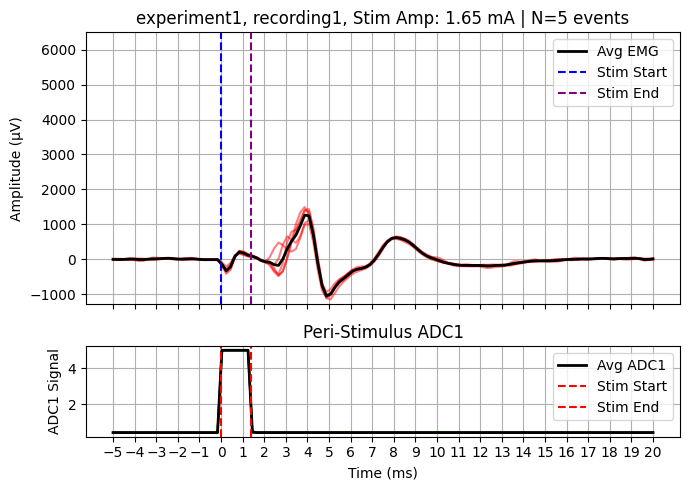

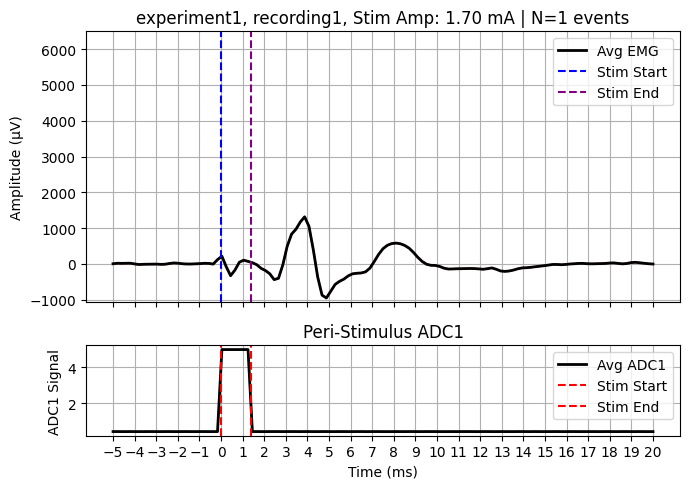

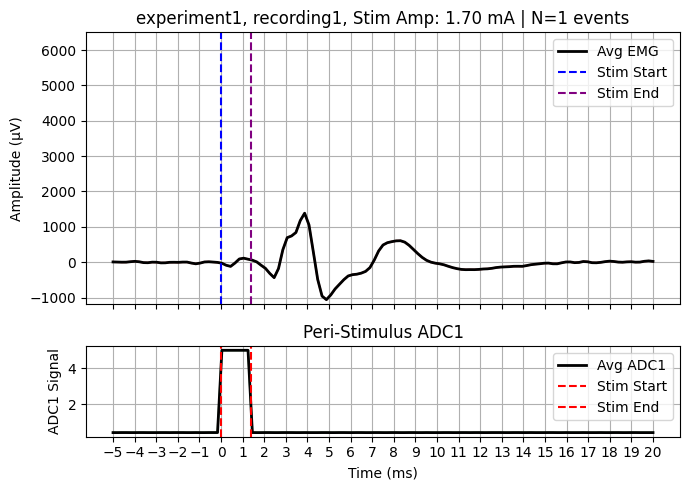

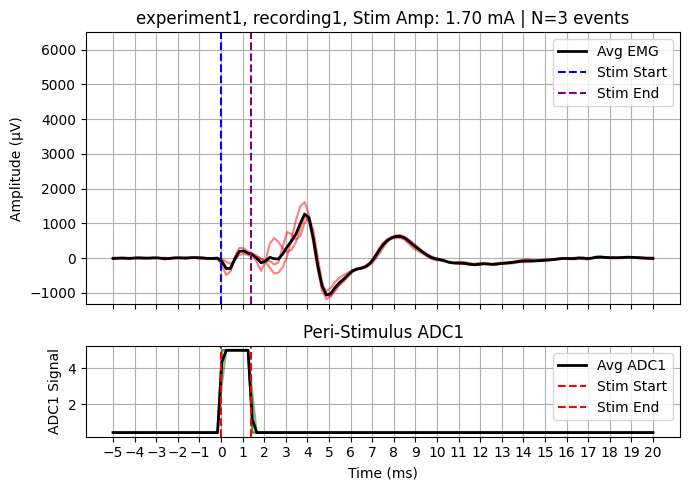

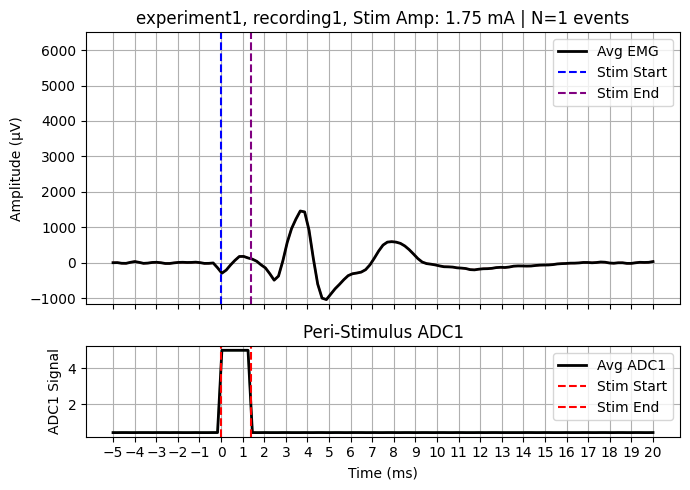

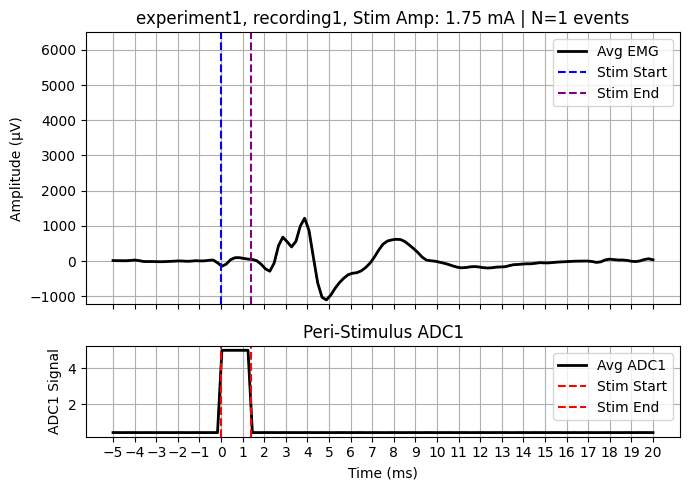

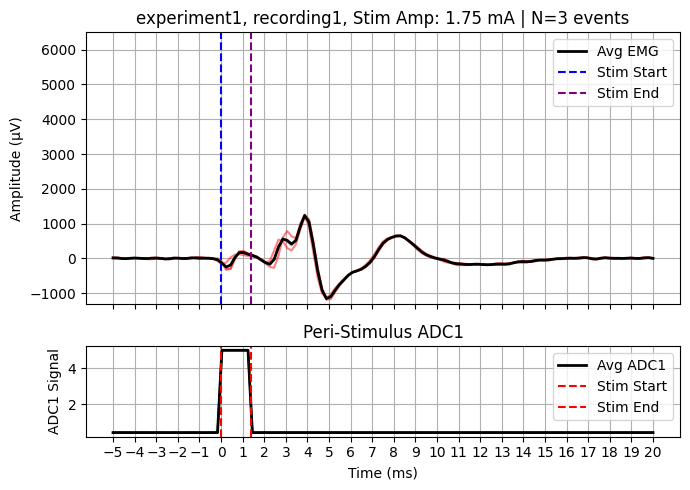

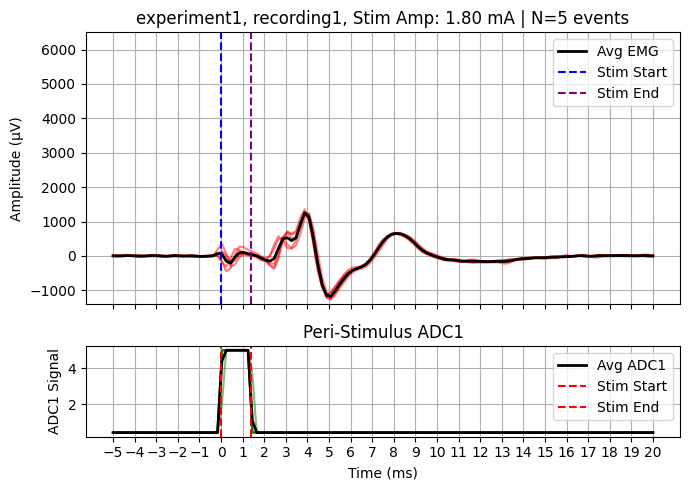

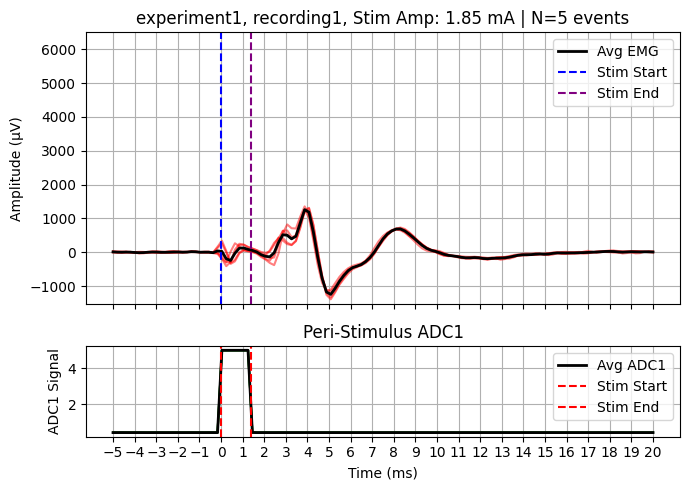

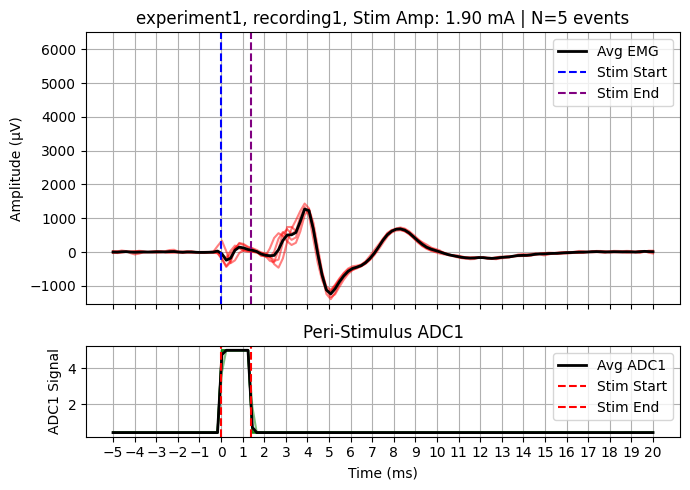

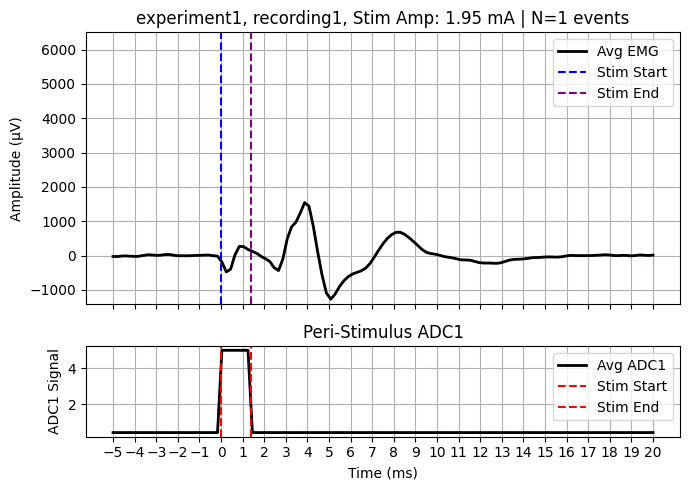

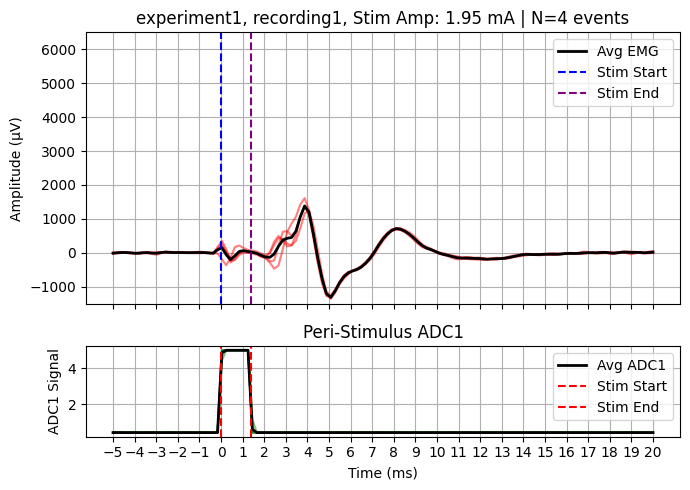

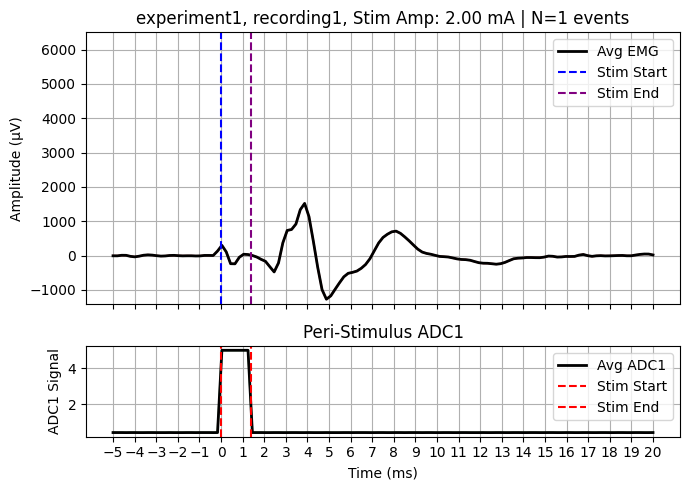

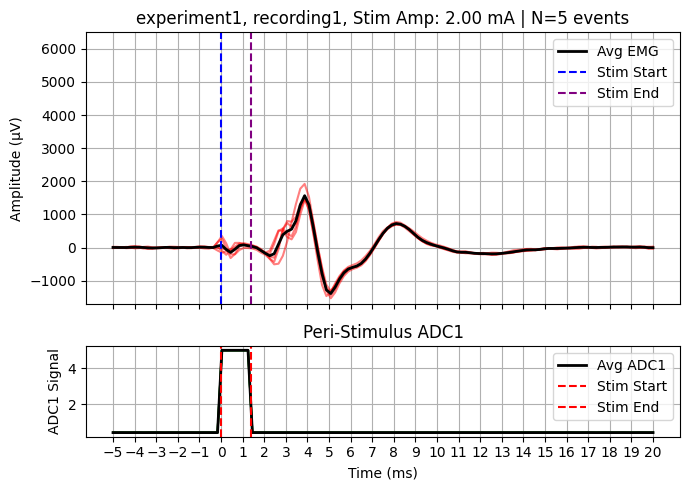

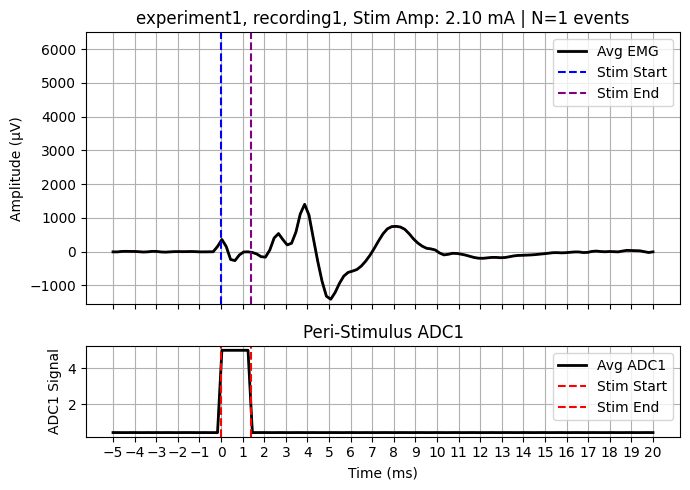

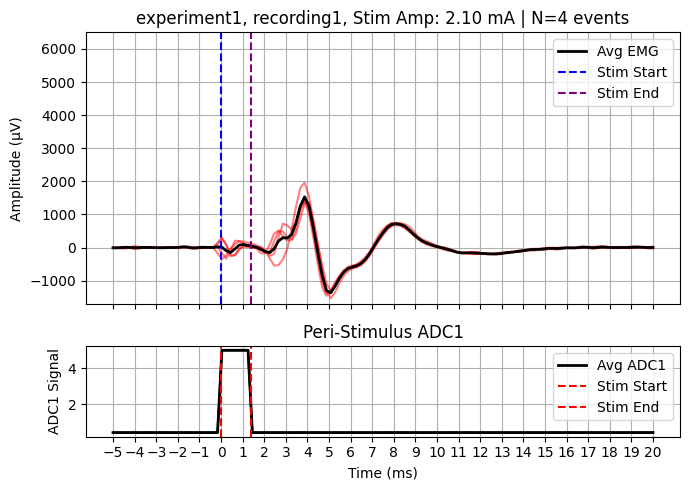

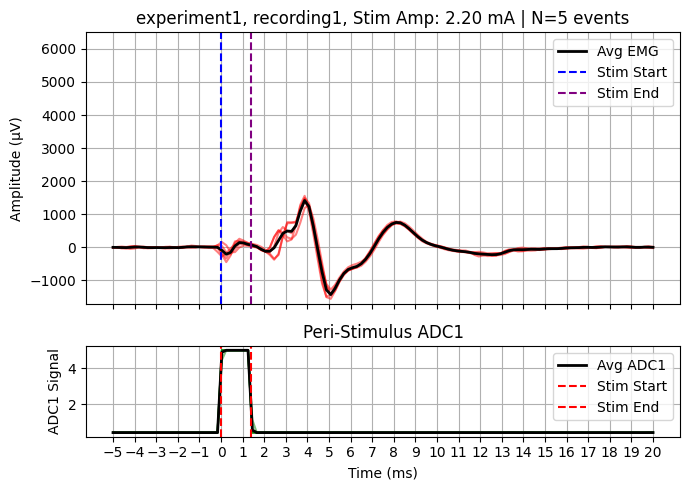

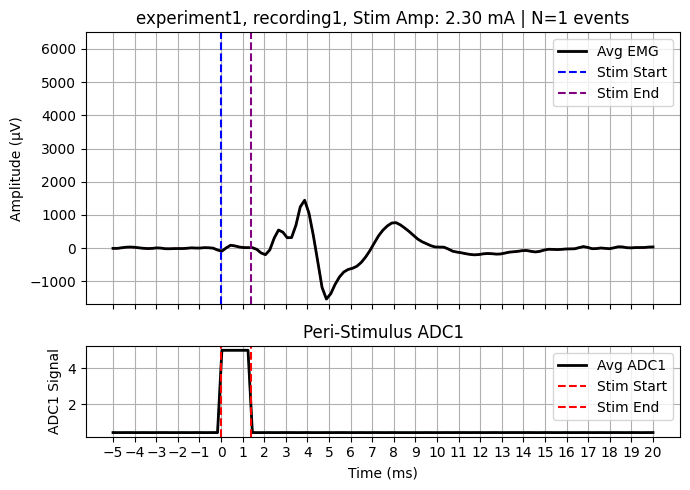

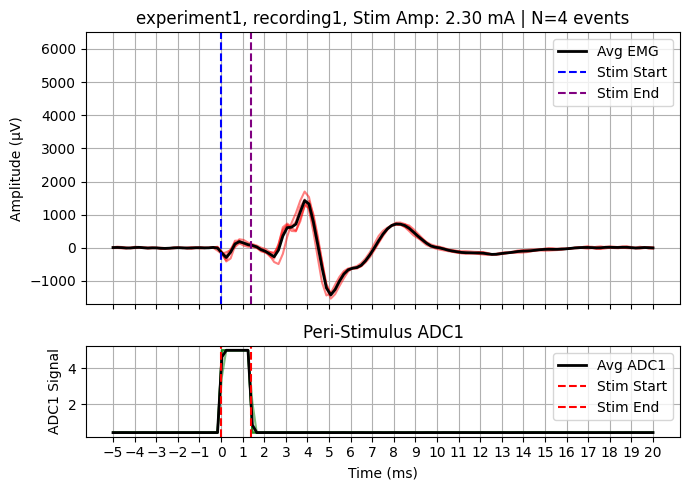

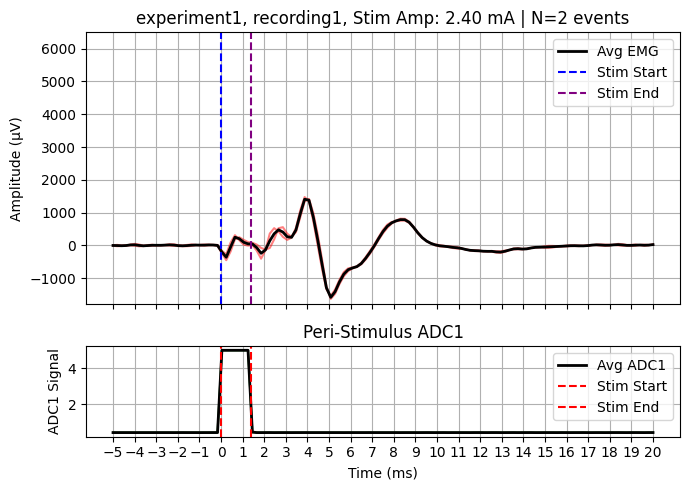

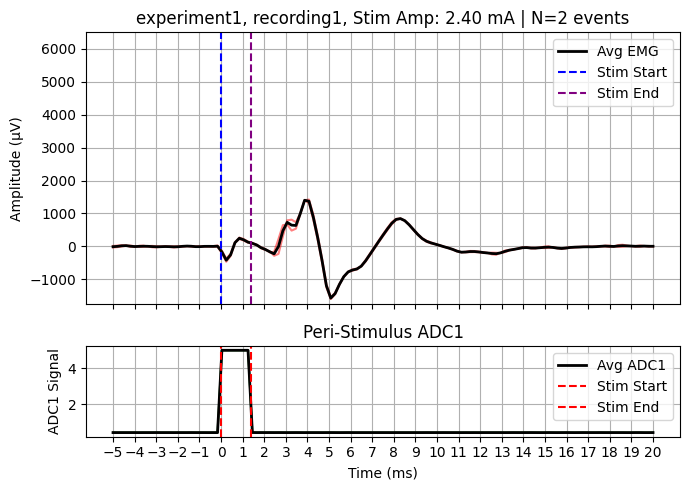

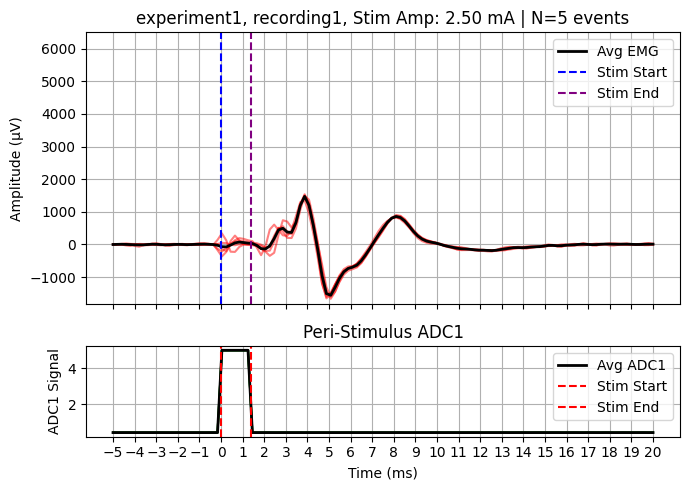

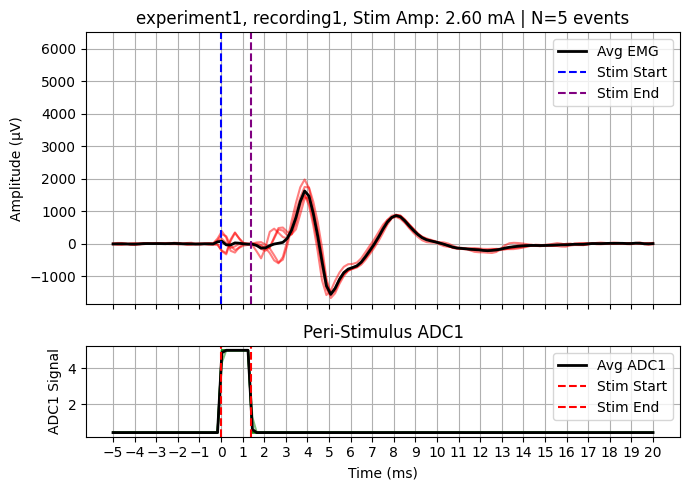

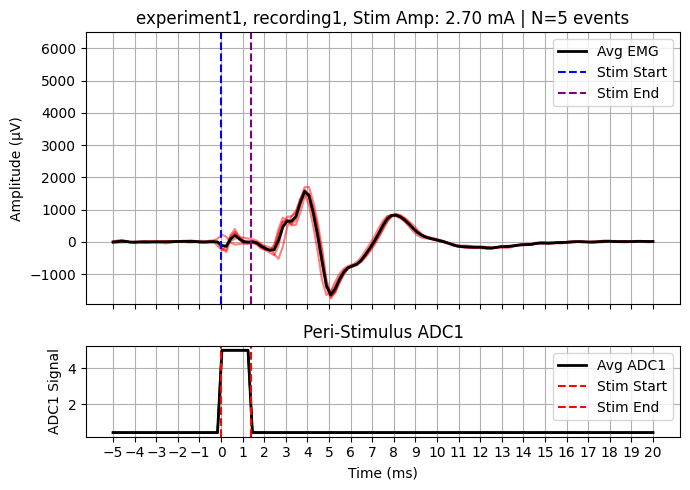

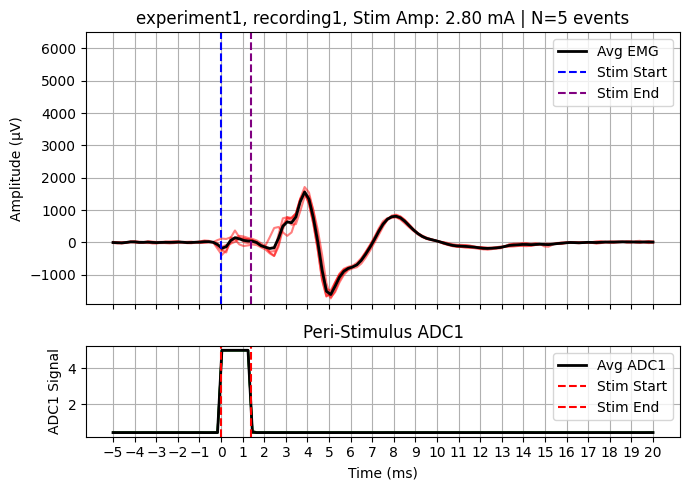

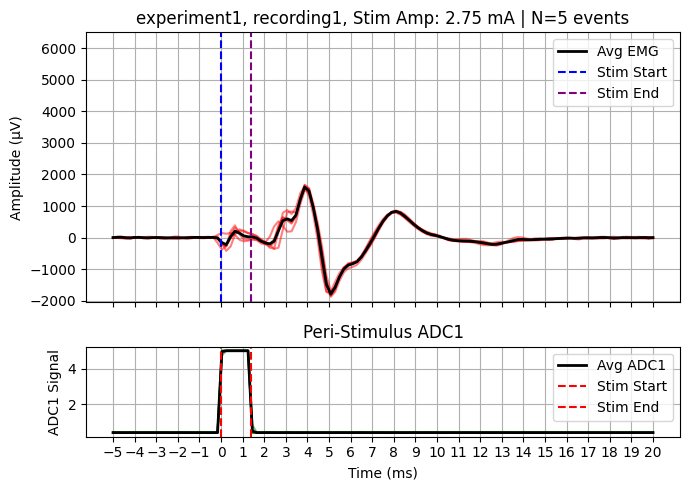

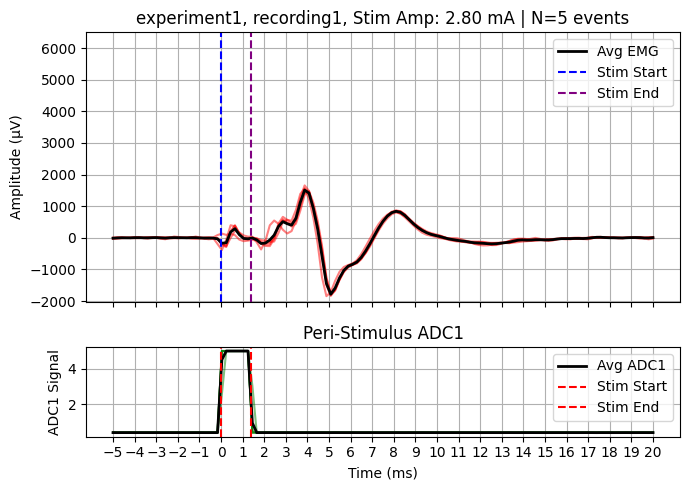

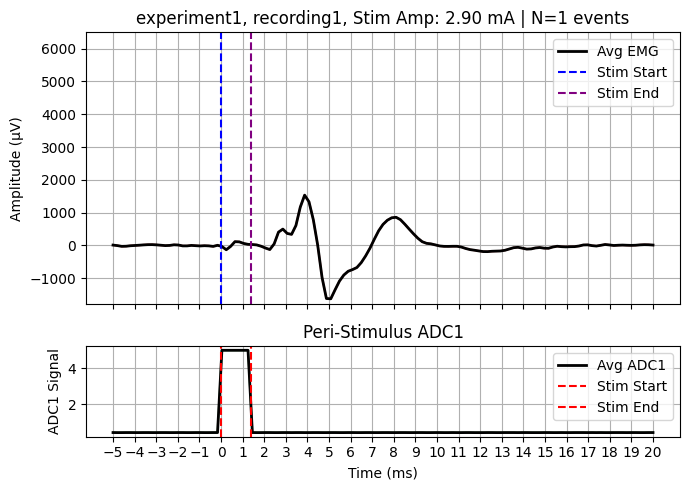

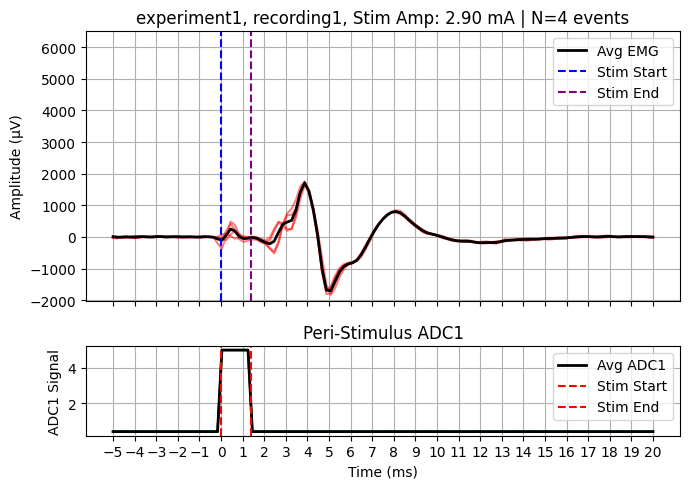

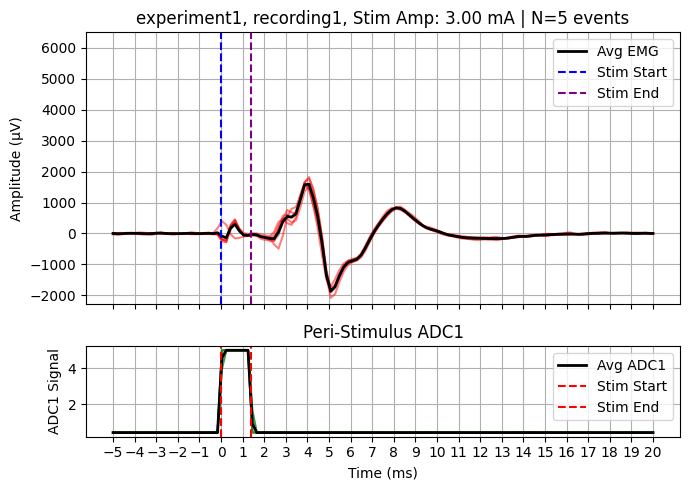

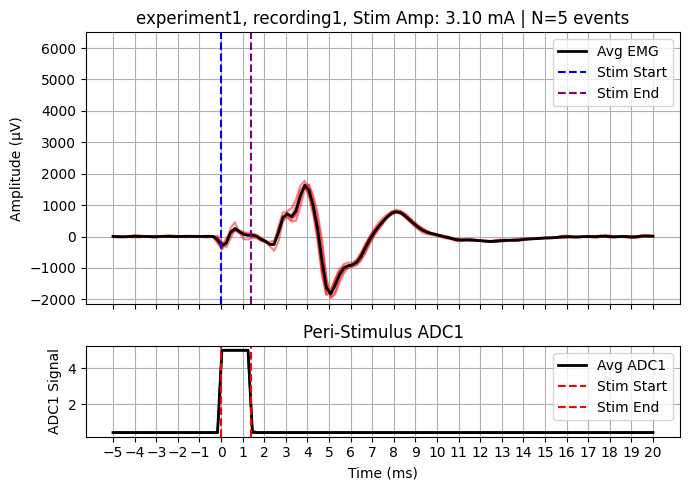

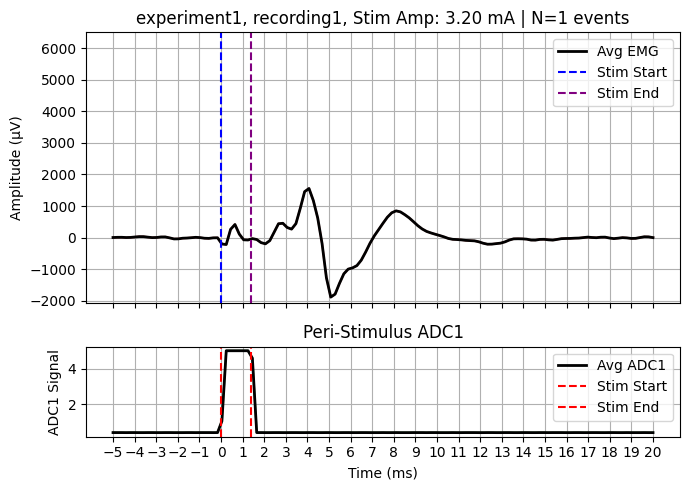

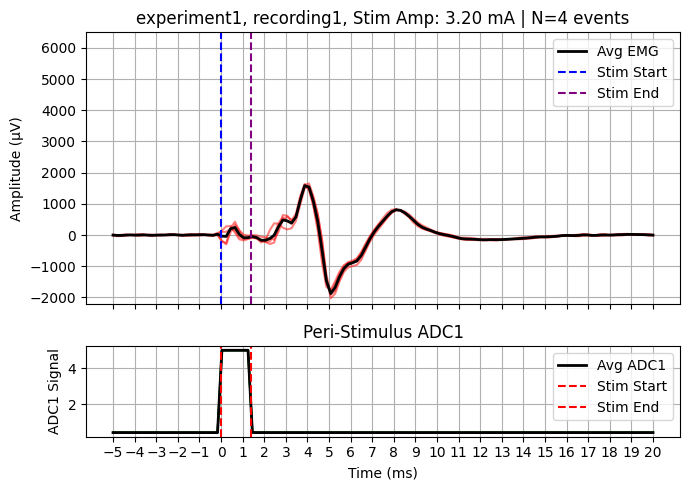

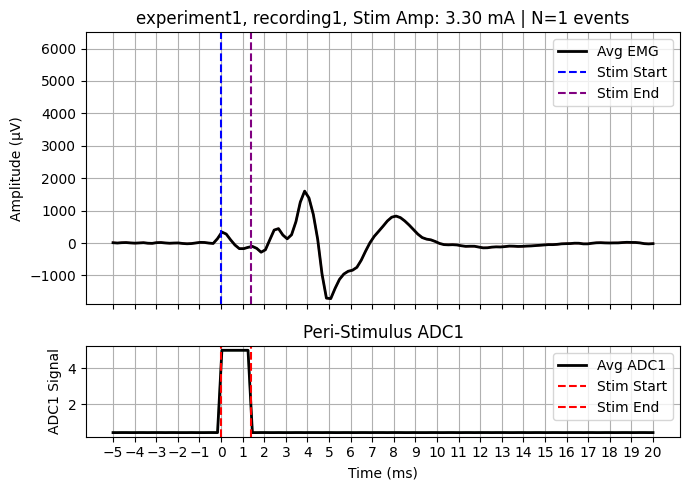

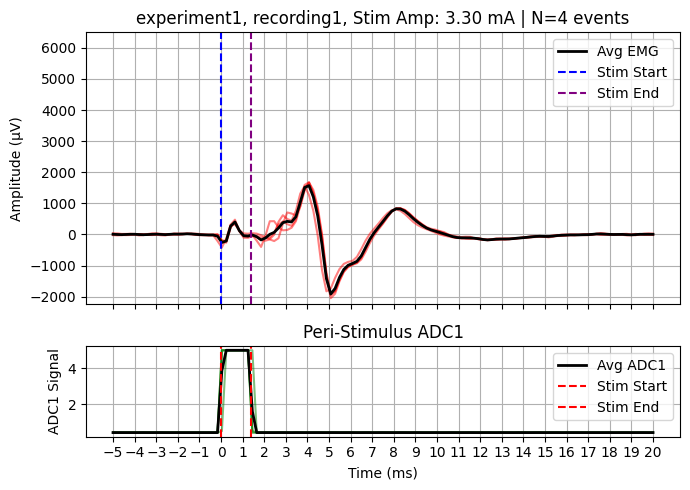

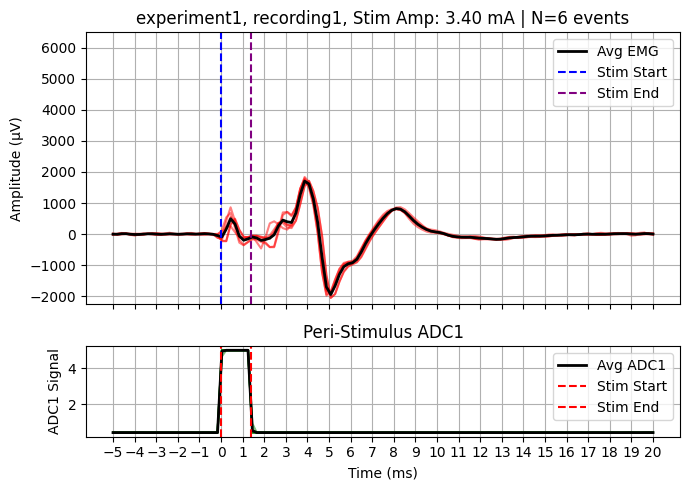

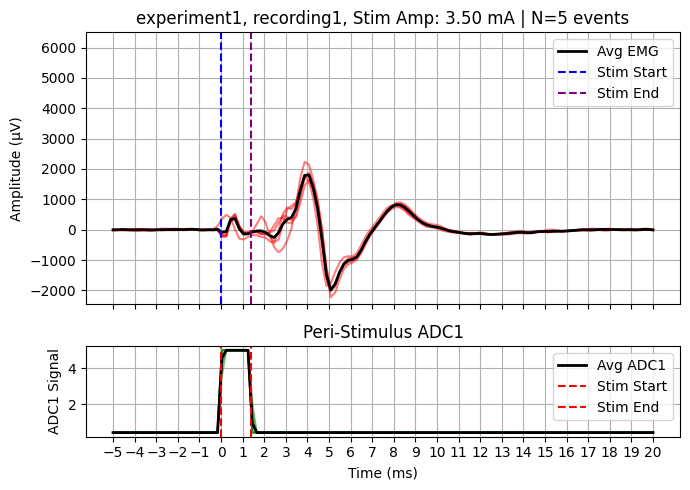

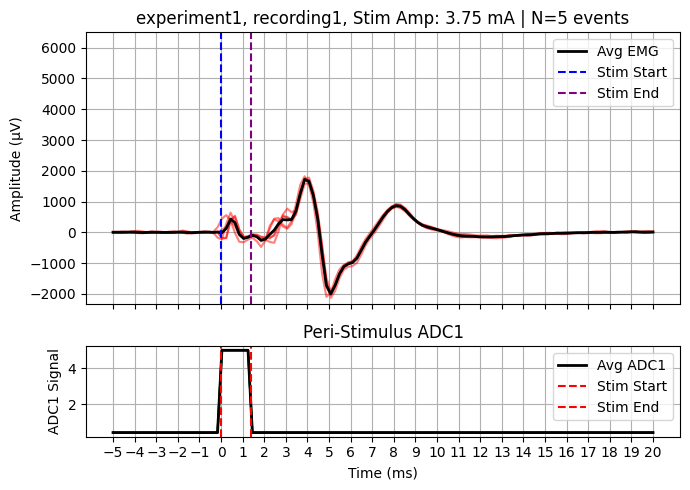

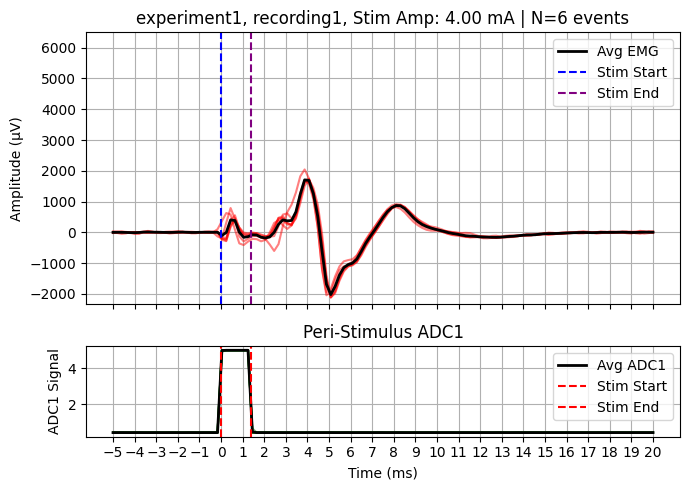

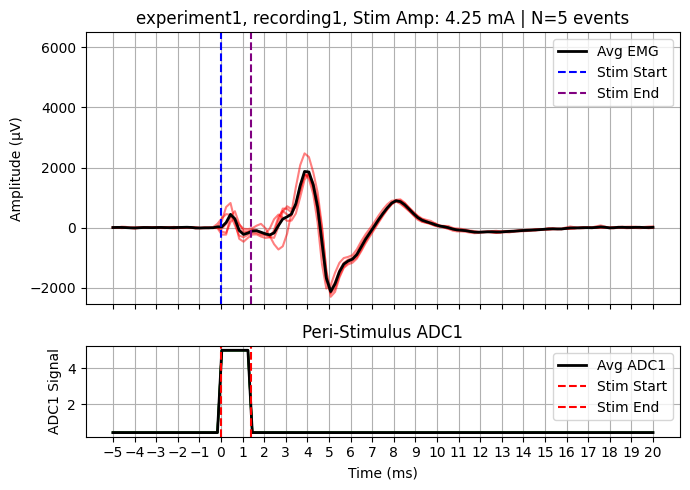

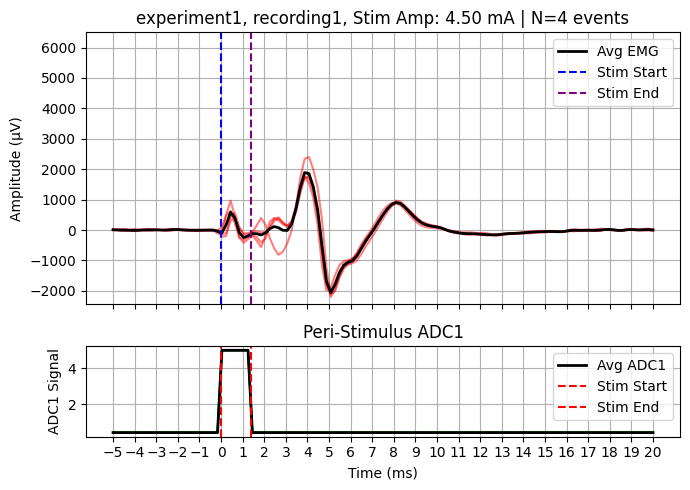

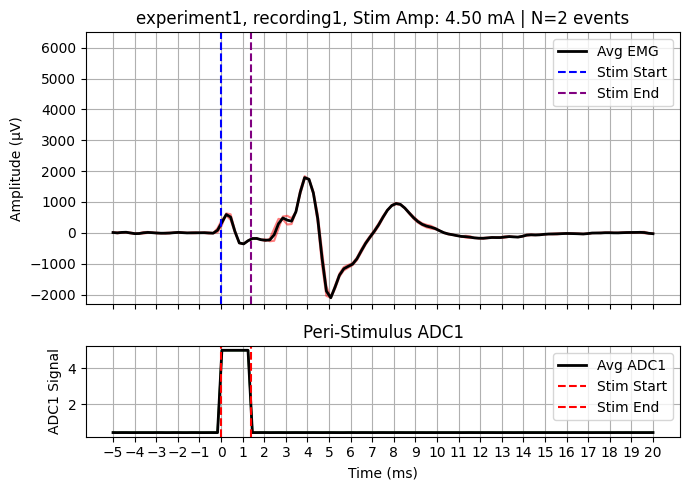

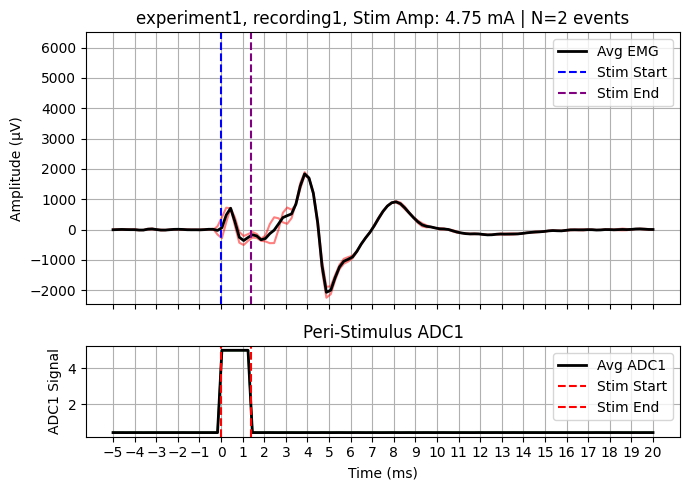

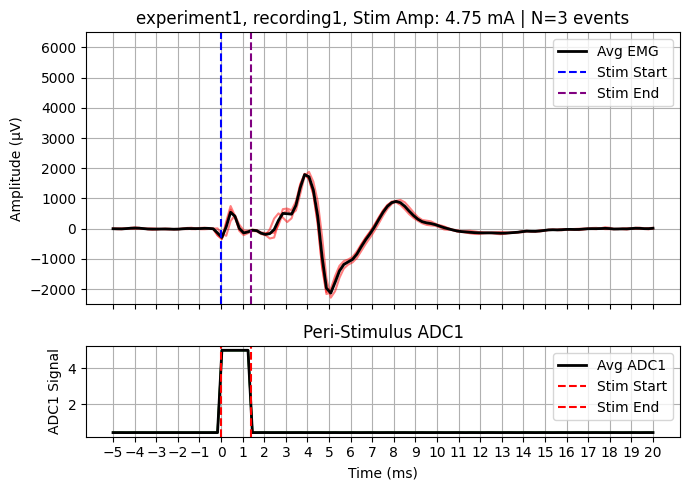

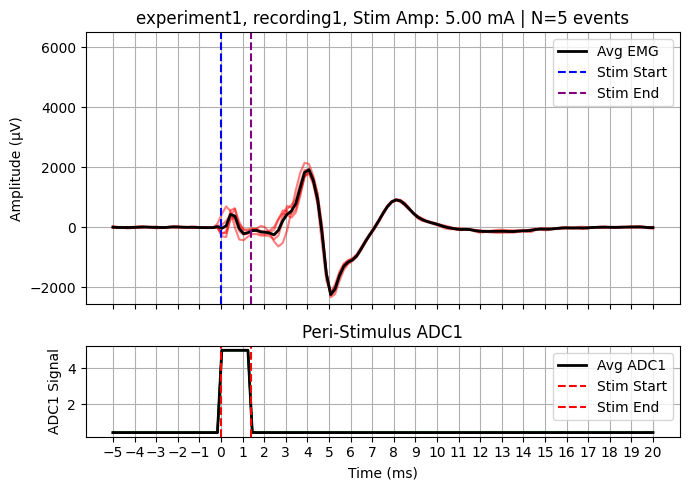

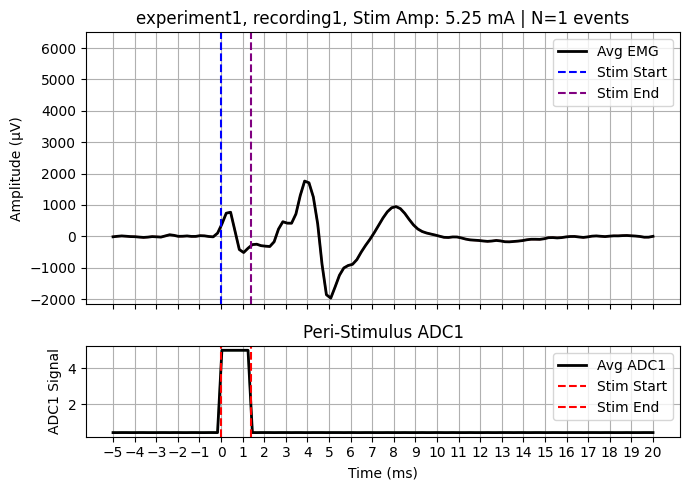

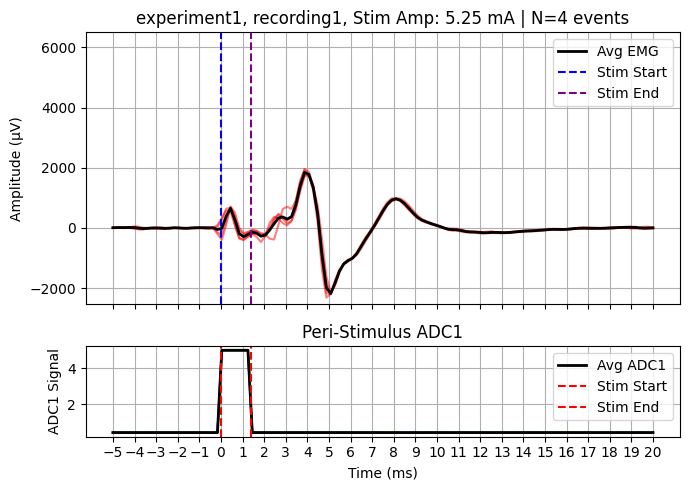

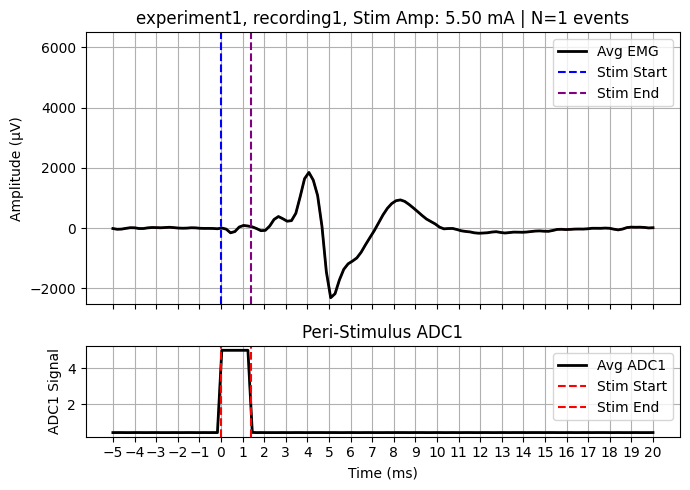

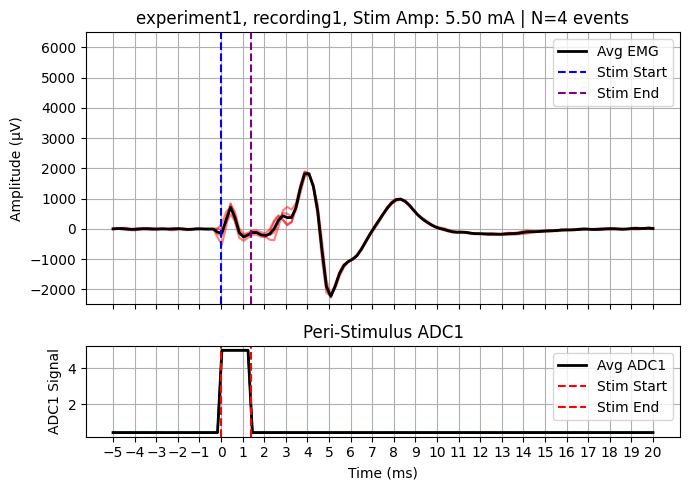

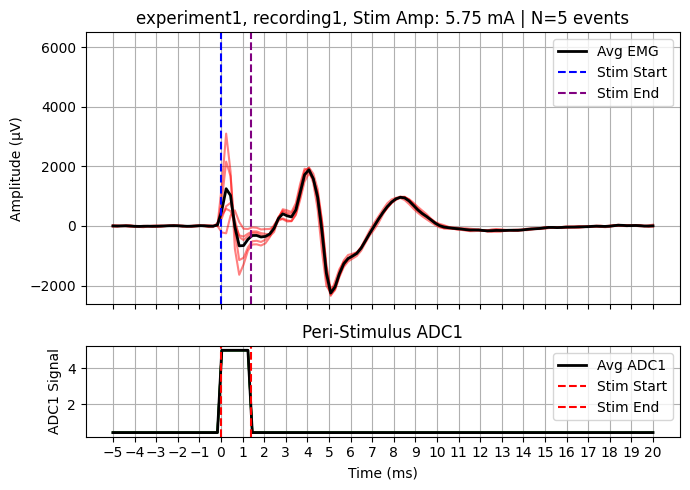

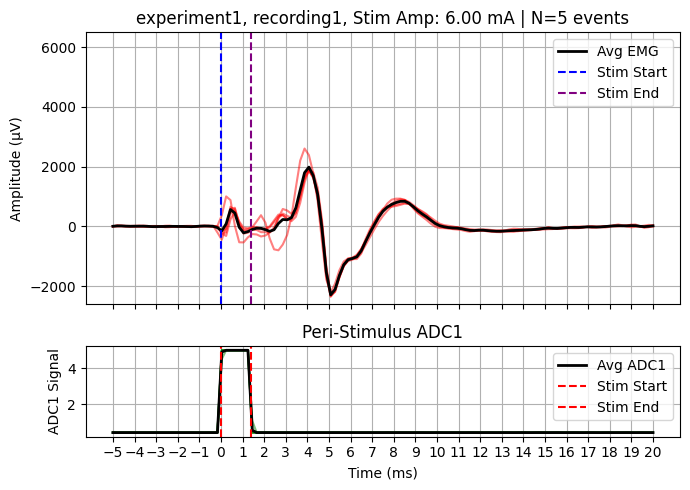

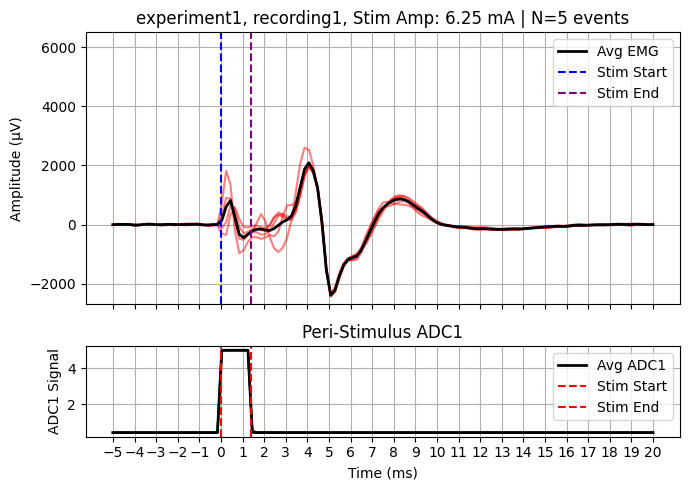

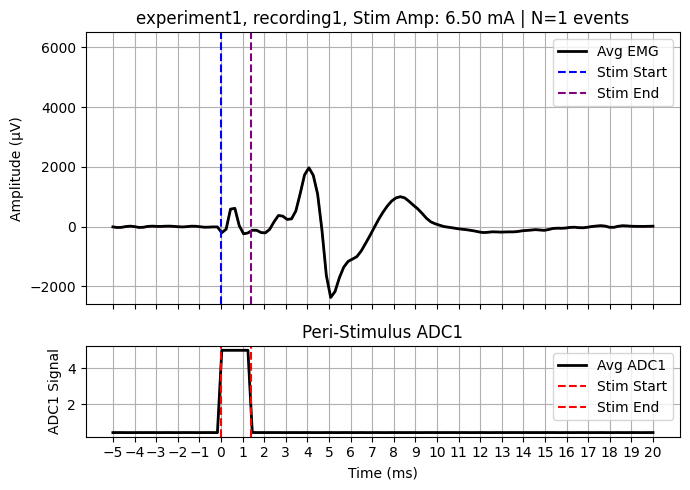

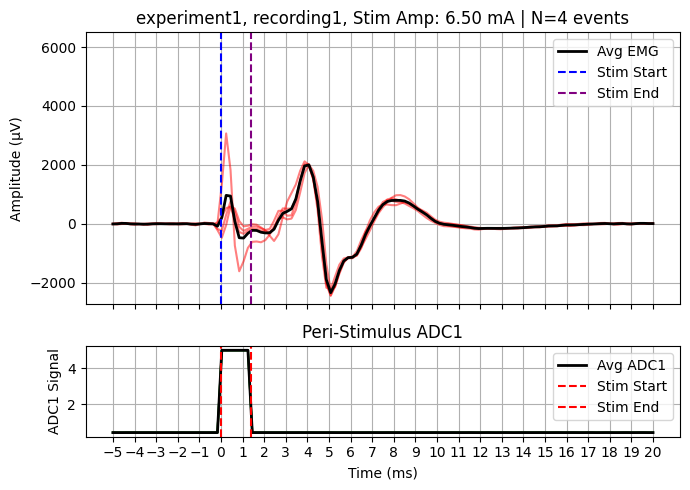

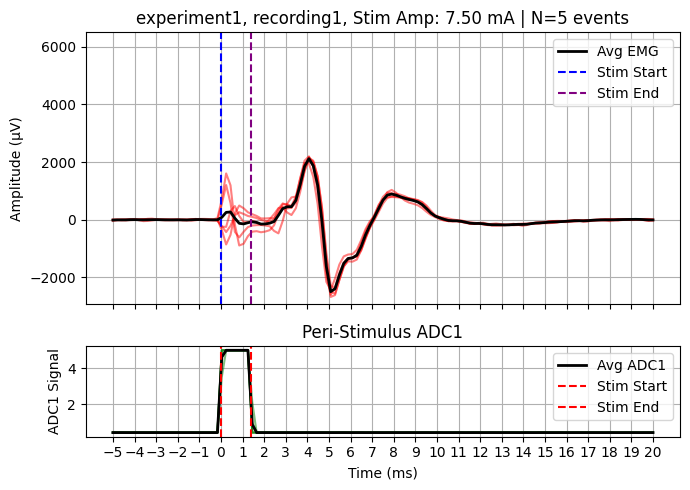


EXPERIMENT1, Recording 2
Open Ephys GUI Recording
ID: 0x148d7056ed0
Format: Binary
Directory: SNARE-38-TEST3_2025-07-24_16-05-17_002\Record Node 111\experiment2\recording1
Experiment Index: 1
Recording Index: 0
Processor ID: 100, Stream Name: Rhythm Data, Line: 1 (main sync line))
  First event sample number: 210177
  Last event sample number: 913690
  Total sync events: 30
  Sample rate: 5000.0
Channels: ['CH1', 'CH5', 'CH7', 'CH11', 'ADC1'] 

MessageCenter directory not found for experiment1/recording2


FileNotFoundError: [Errno 2] No such file or directory: 'SNARE-38-TEST3_2025-07-24_16-05-17_002\\Record Node 111\\experiment1\\recording2\\events\\MessageCenter\\text.npy'

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from open_ephys.analysis import Session
import os
import re
from scipy.signal import butter, filtfilt, lfilter

# ==== Select Session ====
w = 1  # recordnode index

# ==== Define Filters ====

def bandpass_filter(data, fs, lowcut=100, highcut=1000, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return lfilter(b, a, data)

def full_filter(data, fs):
    return bandpass_filter(data, fs)

# ==== Load Session ====
directory = 'SNARE-38-TEST3_2025-07-24_16-05-17_002'
session = Session(directory)
print('Pass Initial Test, Moving on to Loading Session...\n')

for exp in ["experiment1", "experiment2"]:
    for x in range(4):  # up to 4 recordings
        y = f"recording{x + 1}"
        v = f"Record Node 106" if w == 0 else f"Record Node 111"

        try:
            recording = session.recordnodes[w].recordings[x]
        except IndexError:
            print(f"No recording {x+1} found in {exp}")
            

        print(f"\n{exp.upper()}, Recording {x+1}")
        print(recording)

        if not any(sync.get("main", True) for sync in recording.sync_lines):
            recording.add_sync_line(1, 100, 'Rhythm Data', main=True)

        recording.compute_global_timestamps()

        metadata = recording.continuous[0].metadata
        channel_names = metadata['channel_names']
        print("Channels:", channel_names, '\n')

        timestamps = recording.continuous[0].global_timestamps
        data = recording.continuous[0].get_samples(0, len(timestamps))
        sample_rate = metadata['sample_rate']

        emg1_raw = data[:, 2]
        emg2_raw = data[:, 3]
        adc1 = np.abs(data[:, 4])
        differential_emg = full_filter(emg2_raw - emg1_raw, sample_rate)

        events = recording.events
        sync_events = events[(events.line == 1) & (events.processor_id == 100) &
                                (events.stream_name == 'Rhythm Data') & (events.state == 1)]
        sync_timestamps = sync_events['timestamp'].to_numpy()

        messagecenter_dir = os.path.join(directory, v, exp, y, "events", "MessageCenter")
        if not os.path.exists(messagecenter_dir):
            print(f"MessageCenter directory not found for {exp}/{y}")
        

        texts = np.load(os.path.join(messagecenter_dir, "text.npy"), allow_pickle=True)
        timestamps_msg = np.load(os.path.join(messagecenter_dir, "timestamps.npy"))
        decoded_texts = [t.decode('utf-8') if isinstance(t, bytes) else str(t) for t in texts]
        message_entries = list(zip(timestamps_msg, decoded_texts))
        print(f"Loaded {len(decoded_texts)} MessageCenter entries")

        for text, time in zip(decoded_texts, timestamps_msg):
            print(f"[Time: {time:.6f} s] Message: {text}")

        plt.figure(figsize=(15, 4))
        plt.plot(timestamps, differential_emg, label="Filtered EMG1 - EMG2", color='purple')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.title(f"{directory}, {exp}, {y}, Absolute Value Filtered Differential EMG Signal (EMG1 - EMG2)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (μV)")
        plt.grid(True)
        plt.legend()
        plt.ylim(top=6500)
        plt.tight_layout()
        plt.show()

        # ==== Peri-Stimulus Analysis w/ Calculated Stim Start ====
        pre_event_time = 5   # ms before stim start
        post_event_time = 20 # ms after stim start
        stim_threshold = 0.1 # ADC1 threshold
        offstim_threshold = 3

        peri_stim_segments_emg = []
        peri_stim_segments_adc1 = []
        segment_stim_start_times = []
        segment_stim_end_times = []
        segment_stim_center_times = []

        for stamp in sync_timestamps:
            # Locate true stim start
            idx_start = np.searchsorted(timestamps, stamp)
            idx_end   = np.searchsorted(timestamps, stamp + 0.010)
            idx_center = (idx_start + idx_end)/2

            if idx_start < 0 or idx_end > len(timestamps):
                continue

            adc1_seg = adc1[idx_start:idx_end]
            time_seg = timestamps[idx_start:idx_end]

            above_idxs = np.where(adc1_seg > stim_threshold)[0]
            
            if len(above_idxs) == 0:
                continue
            stim_start_idx = idx_start + above_idxs[0]
            stim_start_time = timestamps[stim_start_idx]
            

            idx_pre  = int(stim_start_idx - (pre_event_time/1000)*sample_rate)
            idx_post = int(stim_start_idx + (post_event_time/1000)*sample_rate)
            if idx_pre < 0 or idx_post > len(timestamps):
                continue

            time_window = timestamps[idx_pre:idx_post]
            time_zeroed = time_window - stim_start_time
            adc1_window = adc1[idx_pre:idx_post]

            seg_emg  = differential_emg[idx_pre:idx_post]
            seg_adc1 = adc1[idx_pre:idx_post]

            # Determine stim end
            post_mask = (time_zeroed >= 0)
            adc1_post = seg_adc1[post_mask]
            time_post = time_zeroed[post_mask]
            below_idxs = np.where(adc1_post < offstim_threshold)[0]
            
            stim_end_time = (time_post[below_idxs[0]]*1000 if len(below_idxs)>0 else post_event_time)

            peri_stim_segments_emg.append(seg_emg)
            peri_stim_segments_adc1.append(seg_adc1)
            segment_stim_start_times.append(stim_start_time)
            segment_stim_end_times.append(stim_end_time)


        # ==== Dynamically determine stimulation groups ====
        trigger_pattern = re.compile(r"RHDCONTROL TRIGGER")
        stim_pattern = re.compile(r"starting(?: at)? (\d+\.?\d*)\s*mA", re.IGNORECASE)

        stim_groups = []
        current_group = []
        current_amp = None

        for t, msg in message_entries:
            if stim_pattern.search(msg):
                if current_amp is not None and current_group:
                    stim_groups.append((current_amp, current_group))
                current_amp = float(stim_pattern.search(msg).group(1))
                current_group = []
            elif trigger_pattern.search(msg):
                if current_amp is not None:
                    current_group.append(t)

        if current_amp is not None and current_group:
            stim_groups.append((current_amp, current_group))

        # ==== Match each stim group to detected peri-stim segments ====
        time_ms = np.linspace(-pre_event_time, post_event_time,
                            int((pre_event_time+post_event_time)/1000*sample_rate))

        for stim_amp, trigger_times_group in stim_groups:
            group_emg = []
            group_adc1 = []
            group_end_times = []
            group_start_times = []

            for trig_time in trigger_times_group:
                idx_match = np.argmin(np.abs(np.array(segment_stim_start_times) - trig_time))
                if abs(segment_stim_start_times[idx_match] - trig_time) < 0.1:
                    group_emg.append(peri_stim_segments_emg[idx_match])
                    group_adc1.append(peri_stim_segments_adc1[idx_match])
                    group_end_times.append(segment_stim_end_times[idx_match])
                    group_start_times.append(segment_stim_start_times[idx_match])

            if not group_emg:
                continue

            avg_emg  = np.mean(group_emg, axis=0)
            avg_adc1 = np.mean(group_adc1, axis=0)
            #avg_end_time = np.mean(group_end_times)
            avg_end_time = np.mean(segment_stim_end_times)  # ms after stim start

            fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios':[3,1]})

            for trace in group_emg:
                axs[0].plot(time_ms, trace, color='red', alpha=0.5)
            axs[0].plot(time_ms, avg_emg, color='black', linewidth=2, label='Avg EMG')
            axs[0].axvline(0, color='blue', linestyle='--', label='Stim Start')
            axs[0].axvline(stim_end_time, color='purple', linestyle='--', label='Stim End')
            axs[0].set_title(f"{exp}, {y}, Stim Amp: {stim_amp:.2f} mA | N={len(group_emg)} events")
            axs[0].set_ylabel("Amplitude (μV)")
            axs[0].legend()
            axs[0].grid(True)
            axs[0].set_ylim(top=6500)

            for trace in group_adc1:
                axs[1].plot(time_ms, trace, color='green', alpha=0.5)
            axs[1].plot(time_ms, avg_adc1, color='black', linewidth=2, label='Avg ADC1')
            axs[1].axvline(0, color='red', linestyle='--', label='Stim Start')
            axs[1].axvline(stim_end_time, color='red', linestyle='--', label='Stim End')
            axs[1].set_title("Peri-Stimulus ADC1")
            axs[1].set_xlabel("Time (ms)")
            axs[1].set_ylabel("ADC1 Signal")
            axs[1].legend()
            axs[1].grid(True)
            axs[1].set_xticks(np.arange(int(time_ms[0]), int(time_ms[-1])+1, 1))

            plt.tight_layout()
            plt.show()
    

In [13]:
print(time_zeroed)

[-0.005  -0.0048 -0.0046 -0.0044 -0.0042 -0.004  -0.0038 -0.0036 -0.0034
 -0.0032 -0.003  -0.0028 -0.0026 -0.0024 -0.0022 -0.002  -0.0018 -0.0016
 -0.0014 -0.0012 -0.001  -0.0008 -0.0006 -0.0004 -0.0002  0.      0.0002
  0.0004  0.0006  0.0008  0.001   0.0012  0.0014  0.0016  0.0018  0.002
  0.0022  0.0024  0.0026  0.0028  0.003   0.0032  0.0034  0.0036  0.0038
  0.004   0.0042  0.0044  0.0046  0.0048  0.005   0.0052  0.0054  0.0056
  0.0058  0.006   0.0062  0.0064  0.0066  0.0068  0.007   0.0072  0.0074
  0.0076  0.0078  0.008   0.0082  0.0084  0.0086  0.0088  0.009   0.0092
  0.0094  0.0096  0.0098  0.01    0.0102  0.0104  0.0106  0.0108  0.011
  0.0112  0.0114  0.0116  0.0118  0.012   0.0122  0.0124  0.0126  0.0128
  0.013   0.0132  0.0134  0.0136  0.0138  0.014   0.0142  0.0144  0.0146
  0.0148  0.015   0.0152  0.0154  0.0156  0.0158  0.016   0.0162  0.0164
  0.0166  0.0168  0.017   0.0172  0.0174  0.0176  0.0178  0.018   0.0182
  0.0184  0.0186  0.0188  0.019   0.0192  0.0194  0.0